In [1]:
library(tidyverse)
library(repr)
library(cowplot)
library(ggseqlogo)
library(reshape2)
library(ggmsa)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Registered S3 methods overwritten by 'ggalt':
  method                  from   
  grid.draw.absoluteGrob  ggplot2
  grobHeight.absoluteGrob ggplot2
  grobWidth.absoluteGrob  ggplot2
  grobX.absoluteGrob      ggplot2
  grobY.absoluteGrob      ggplot2

ggmsa v1.3.4  Document:

In [2]:
cols = c('chromosome', 'reference_nucleotide', 'position', 'trinuc_context','dinuc_context', 
         "methylation_frequency", "count_mC", "coverage")

TS559exoS <- read.delim('../processed_cgmaps/bs7v1/TS559exoS_coverage', sep='\t') %>%
    dplyr::rename(
          methylation_frequency_TS559_rep1 = methylation_frequency_TS559_March2016,
          mC_count_TS559_rep1 = mC_count_TS559_March2016,
          coverage_TS559_rep1 = coverage_TS559_March2016,
        
          methylation_frequency_TS559_rep2 = methylation_frequency_TS559_Dec2016,
          mC_count_TS559_rep2 = mC_count_TS559_Dec2016,
          coverage_TS559_rep2 = coverage_TS559_Dec2016,
           
          methylation_frequency_TS559_rep3 = methylation_frequency_TS559_Oct2020,
          mC_count_TS559_rep3 = mC_count_TS559_Oct2020,
          coverage_TS559_rep3 = coverage_TS559_Oct2020
          )

annotation <- data.frame(read.delim('/home/kristin/jupyter_notebooks/RNA_mt_proj/bs7/annotation_ready', sep = '\t') %>%
    dplyr::rename(position=TS559_position) )

folds_65C <-read.delim('./data/MTase_positions_annotation_65.tsv', sep = '\t') %>%
    dplyr::select(TS559_position, element_name,element_type, logos_sequence_41bp, local_41bp_predicted_fold,MFE )

folds_85C <-read.delim('./data/MTase_positions_annotation_85.tsv', sep = '\t') %>%
    dplyr::select(TS559_position, element_name,element_type,logos_sequence_41bp, local_41bp_predicted_fold,MFE )


In [3]:
# HELPERS 


#' load_cgmap()
#' This function will load a text file containing CGmaps and add column headers
#'
#' @param cgmap path to CGmaps
#' @param strain strain designator (i.e "TS559", "TK2304", etc)
#' @param replicate i.e. "rep1"
#' @param growth phae exponential" or "stationary"
#' @param metabolic_condition S for sulfur
#'
#' @return dataframe 
load_cgmap <- function(cgmap,strain, replicate, growth_phase, metabolic_condition='S'){
    cols = c('chromosome', 'base', 'position', 'trinuc_context','dinuc_context', 
         "methylation_frequency", "count_mC", "coverage")
    outdata <- read.delim(cgmap, sep='\t', header=FALSE,col.names=cols) %>%
        mutate(strain=strain, growth_phase=growth_phase, 
               metabolic_condition=metabolic_condition, replicate=replicate)

}


#' processCGmap()
#' Fix some of the column names so they are unique for each strain
#'
#' @param cgmap: path to CGmaps
#'
#' @return dataframe 
processCGmap <- function(cgmap){
    strain = unique(cgmap$strain)
    rep = unique(cgmap$replicate)
    
    final_data <- cgmap %>% 
        dplyr::select(-trinuc_context, -dinuc_context) %>%
        dplyr::rename(!!paste("coverage","_",strain,"_",rep, sep="") := coverage) %>%
        dplyr::rename(!!paste("mC_count","_",strain,"_",rep, sep="") := count_mC) %>%
        dplyr::rename(!!paste("methylation_frequency","_",strain,"_",rep, sep="") := methylation_frequency) %>%
        dplyr::select(-replicate, -strain)
    return(final_data)
}


#' merge_del_2reps()
#' merge processed CGmaps for replicate deletion strains when there are 2 replicates
#'
#' @param x: processCGmap output for rep1
#' @param y: processCGmap output for rep2
#' @param strain: name of strain (i.e. "TS559", "TK2304", etc)
#'
#' @return dataframe 
merge_del_reps <- function(x,y, strain){
    cov_1 <- paste("coverage_",strain, "_rep1", sep='')
    cov_2 <- paste("coverage_",strain, "_rep2", sep='')

    d <- x %>%
        merge(y=y, 
              by=c("chromosome","position", 'reference_nucleotide', 'growth_phase','metabolic_condition'), 
              all=TRUE) %>%
    
            mutate(!!as.name(cov_1) := replace_na(!!as.name(cov_1),0)) %>%
            mutate(!!as.name(cov_2) := replace_na(!!as.name(cov_2),0))
    
    return(d)
}


#' merge_del_3reps()
#' merge processed CGmaps for replicate deletion strains when there are 3 replicates
#'
#' @param x: processCGmap output for rep1
#' @param y: processCGmap output for rep2
#' @param y: processCGmap output for rep3
#' @param strain: name of strain (i.e. "TS559", "TK2241", etc)
#'
#' @return dataframe
merge_del_3reps <- function(x,y,z,strain){
    cov_1 <- paste("coverage_",strain, "_rep1", sep='')
    cov_2 <- paste("coverage_",strain, "_rep2", sep='')
    cov_3 <- paste("coverage_",strain, "_rep3", sep='')

    d <- x %>%
        merge(y=y, 
              by=c("chromosome","position", 'reference_nucleotide', 'growth_phase','metabolic_condition'), 
              all=TRUE) %>%
        merge(y=z, 
              by=c("chromosome","position", 'reference_nucleotide', 'growth_phase','metabolic_condition'), 
              all=TRUE) %>%
            mutate(!!as.name(cov_1) := replace_na(!!as.name(cov_1),0)) %>%
            mutate(!!as.name(cov_2) := replace_na(!!as.name(cov_2),0)) %>%
            mutate(!!as.name(cov_3) := replace_na(!!as.name(cov_3),0))

    return(d)
}


#' detect_hiconf_3reps()
#' Determine if high confidence, reproducible sites when there are 3 replicates

#' @param f  measured m5C frequency
#' @param m  measured m5C coverage
#' @param p  99 percentile m5C coverage
#' @param c  total coverage
#' @param min_cov  minimum coverage for high confidence threshold
#' @param min_freq  .1 minimum m5C frequency high confidence threshold
#' @param min_freq2  ..5 minimum m5C frequency high confidence threshold when coverage >=1000
#'
#' @return TRUE, FALSE, NA
detect_hiconf_3reps <- function(f1,m1,p1,c1,f2,m2,p2,c2,f3,m3,p3,c3, min_cov=47,
                                min_freq=.10, min_freq2 = 0.05) {
    ls <- c()
    
    if( is.na(c1) ) {c1<-0}
    if( is.na(c2) ) {c2<-0}
    if( is.na(c3) ) {c3<-0}
    if(c1 < min_cov & c2 < min_cov & c3 < min_cov) {return(NA)}
    
    else{
    
    if(c1<min_cov){ls <- c(ls,NA)}
    else if(  (c1>=min_cov & m1>=p1 & f1>=min_freq) | (m1>50 & f1>=min_freq2) ) {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}
    
    if(c2<min_cov){ls <- c(ls,NA)}
    else if( (c2>=min_cov & m2>=p2 & f2>=min_freq) | (m2>50 & f2>=min_freq2) ) {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}
    
    if(c3<min_cov){ls <- c(ls,NA)}
    else if( (c3>=min_cov & m3>=p3 & f3>=min_freq)| (m3>50 & f3>=min_freq2) )  {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}
    
    ans_t <- length(which(ls==TRUE))
    ans_na <- length(which(ls==NA))
    ans_f <- length(which(ls==FALSE))

    if(ans_na >= 3){return(NA)}
    if(ans_na == 2 & ans_t == 1){return(NA)}
    else if(ans_t >= 2){return(TRUE)}
    else { return(FALSE)}
        }
}


#' detect_hiconf_2reps()
#' Determine if high confidence, reproducible sites when there are 2 replicates

#' @param f  measured m5C frequency
#' @param m  measured m5C coverage
#' @param p  99 percentile m5C coverage
#' @param c  total coverage
#' @param min_cov  minimum coverage for high confidence threshold
#' @param min_freq  .1 minimum m5C frequency high confidence threshold
#' @param min_freq2  ..5 minimum m5C frequency high confidence threshold when coverage >=1000
#'
#' @return TRUE, FALSE, NA
detect_hiconf_2reps <- function(f1,m1,p1,c1,f2,m2,p2,c2, min_cov=47,
                                min_freq=.10, min_freq2 = 0.05) {
    ls <- c()
    
    if( is.na(c2) ) {c1<-0}
    if( is.na(c2) ) {c2<-0}
    
    if(c1 < min_cov & c2 < min_cov) {return(NA)}
    else{
            
    if(c1<min_cov){ls <- c(ls,NA)}
    else if(  (c1>=min_cov & m1>=p1 & f1>=min_freq) | (m1>50 & f1>=min_freq2) ) {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}
    
    if(c2<min_cov){ls <- c(ls,NA)}
    else if( (c2>=min_cov & m2>=p2 & f2>=min_freq) | (m2>50 & f2>=min_freq2) ) {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}

    ans_t <- length(which(ls==TRUE))
    ans_na <- length(which(ls==NA))
    ans_f <- length(which(ls==FALSE))

    if(ans_f == 1 & ans_t == 1 ){return(TRUE)}
    if(ans_f >= 1  ){return(FALSE)}
    else if(ans_t >= 2){return(TRUE)}
    else if(ans_t == 1 & ans_na ==1){return(TRUE)}
    else if(ans_f == 1 & ans_na ==1){return(FALSE)}

    else { return(NA)}
        
        }
}


#' super_hiconf_3reps()
#' Determine if high confidence in all 3 replicates (super high confidence)

#' @param f  measured m5C frequency
#' @param m  measured m5C coverage
#' @param p  99 percentile m5C coverage
#' @param c  total coverage
#' @param min_cov  minimum coverage for high confidence threshold
#' @param min_freq  .1 minimum m5C frequency high confidence threshold
#' @param min_freq2  ..5 minimum m5C frequency high confidence threshold when coverage >=1000
#'
#' @return TRUE, FALSE, NA
super_hiconf_3reps <- function(f1,m1,p1,c1,f2,m2,p2,c2,f3,m3,p3,c3, min_cov=47,
                                min_freq=.10, min_freq2 = 0.05) {
    ls <- c()
    
    if( is.na(c1) ) {c1<-0}
    if( is.na(c2) ) {c2<-0}
    if( is.na(c3) ) {c3<-0}

    
    if(  (c1>=min_cov & m1>=p1 & f1>=min_freq) | (c1>1000 & f1>=min_freq2)  ) {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}
    
    
    if( (c2>=min_cov & m2>=p2 & f2>=min_freq) | (c2>=1000 & f2>=min_freq2) ) {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}
    
    if( (c3>=min_cov & m3>=p3 & f3>=min_freq) | (c3>=1000 & f3>=min_freq2) )  {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}
    
    ans <- length(which(ls==TRUE))
    
    if(ans >= 3){return(TRUE)}
    else { return(FALSE)}
}



#' rm_overlap()
#' Determine if the deletion strain and parent/control strain m5C frequencies have  
#'    a 90% confidence interval overlap 

#' @param sp  deletion strain m5C frequency
#' @param ssd deletion strain m5C frequency standard deviation
#' @param c  control strain m5C frequency
#' @param csd control strain m5C frequency standard deviation
#'
#' @return TRUE, FALSE
rm_overlap <- function(sp, ssd, cp,csd){
    ssd <- ssd*1.645
    csd <- csd*1.645

    r1 <- c(sp-ssd, sp+ssd)
    r2 <- c(cp-csd, cp+csd)
    ans <- r1 %overlaps% r2
    return(ans)
    
}


#' get_sd()
#' Calculate m5C frequency standard deviation when 3 replicates are available
#'
#' @param f1  m5C frequency rep1
#' @param f2  m5C frequency rep2
#' @param f3  m5C frequency rep3
#' @param c1 site coverage rep1
#' @param c2 site coverage rep2
#' @param c3 site coverage rep3

#' @return standard deviation
get_sd <- function(f1,f2,f3,c1,c2,c3,min_cov){
    ls <-c()
    
    if(c1>=min_cov){
        ls <- c(ls,f1)
    }
    if(c2>=min_cov){
        ls <- c(ls, f2)

    }
    
    if(c3>=min_cov){
       ls <- c(ls, f3)

    }
    if (length(ls>1)){
        ans = round(sd(ls),3)
    } else{
        ans = NA
    }
    return(ans)
}


#' get_sd_2reps()
#' Calculate m5C frequency standard deviation when 2 replicates are available
#'
#' @param f1  m5C frequency rep1
#' @param f2  m5C frequency rep2
#' @param f3  m5C frequency rep3
#' @param c1 site coverage rep1
#' @param c2 site coverage rep2
#' @param c3 site coverage rep3

#' @return standard deviation
get_sd_2reps <- function(f1,f2,c1,c2,min_cov=47){
    ls <-c()
    if(c1>=min_cov){
        ls <- c(ls,f1)
    }
    if(c2>=min_cov){
        ls <- c(ls, f2)
    }
    if (length(ls>1)){
        ans = round(sd(ls),3)
    } else{
        ans = NA
    }
    return(ans)
}


#' get_pvalue()
#' get p value for each m5C site using binomial distribution when 2 replicates available for deletion strain
#'    the m5C and total coverage are pooled accross replicates.

#' @param s1_mC  deletion strain rep1 m5C coverage
#' @param s1_cov deletion strain rep1 total coverage
#' @param s2_mC  deletion strain rep2 m5C coverage
#' @param s2_cov deletion strain rep2 total coverage
#' @param c1_mC  control strain rep1 m5C coverage
#' @param c1_cov control strain rep1 total coverage
#' @param c2_mC  control strain rep2 m5C coverage
#' @param c2_cov control strain rep2 total coverage
#' @param c3_mC  control strain rep3 m5C coverage
#' @param c3_cov control strain rep3 total coverage
#'
#' @return pvalue
get_pvalue <- function(s1_mC,s1_cov, s2_mC,s2_cov,
                       c1_mC,c1_cov,c2_mC,c2_cov,c3_mC,c3_cov){
    
    
    if(s1_cov == 0 & s2_cov == 0){return(NA)} 
    if(c1_cov == 0 & c2_cov == 0){return(NA)} 

    else{

    sample_success = s1_mC + s2_mC  + 1
    sample_failure = (s1_cov+s2_cov)-sample_success  +1
    
    control_success = c1_mC + c2_mC + c3_mC  +1
    control_failure = (c1_cov + c2_cov + c3_cov) - control_success  +1
    
    if(is.na(sample_failure) |  is.na(control_failure) |
      is.na(sample_failure) | is.na(sample_failure)
      
      ){return(NA)}
    
    treatment <- c('sample','control')
    success <- c(sample_success, control_success)
    failure <- c(sample_failure, control_failure)
        
    da <- data.frame(treatment, success, failure)
        da$success <- as.integer(da$success)
        da$failure <- as.integer(da$failure)
        da$treatment <- as.factor(da$treatment)

        table <- cbind(da$success,da$failure)

    fit <- glm(table ~ treatment, family = binomial, data = da)
    p_val <- summary(fit)$coefficients[8]
    return(p_val) 
    }
}


#' get_pvalue_3reps()
#' get p value for each m5C site using binomial distribution when 2 replicates available for deletion strain
#'    the m5C and total coverage are pooled accross replicates.

#' @param s1_mC  deletion strain rep1 m5C coverage
#' @param s1_cov deletion strain rep1 total coverage
#' @param s2_mC  deletion strain rep2 m5C coverage
#' @param s2_cov deletion strain rep2 total coverage
#' @param s3_mC  deletion strain rep3 m5C coverage
#' @param s3_cov deletion strain rep3 total coverage
#' @param c1_mC  control strain rep1 m5C coverage
#' @param c1_cov control strain rep1 total coverage
#' @param c2_mC  control strain rep2 m5C coverage
#' @param c2_cov control strain rep2 total coverage
#' @param c3_mC  control strain rep3 m5C coverage
#' @param c3_cov control strain rep3 total coverage
#'
#' @return pvalue
get_pvalue_3reps <- function(s1_mC,s1_cov, s2_mC,s2_cov,s3_mC,s3_cov,
                       c1_mC,c1_cov,c2_mC,c2_cov,c3_mC,c3_cov){
    
    
    if(s1_cov == 0 & s2_cov==0 & s3_cov == 0){return(NA)} 
    if(c1_cov == 0 & c2_cov==0 & c3_cov == 0){return(NA)} 

    sample_success = s1_mC + s2_mC + s3_mC +1
    sample_failure = (s1_cov + s2_cov + s3_cov)-sample_success +1
    
    control_success = c1_mC + c2_mC + c3_mC +1
    control_failure = (c1_cov + c2_cov + c3_cov) - control_success +1
        
    if(is.na(sample_failure) |  is.na(control_failure) |
      is.na(sample_failure) | is.na(sample_failure) ){return(NA)}
    
    treatment <- c('sample','control')
    success <- c(sample_success, control_success)
    failure <- c(sample_failure,control_failure)
        
    da <- data.frame(treatment, success, failure)
        da$success <- as.integer(da$success)
        da$failure <- as.integer(da$failure)
        da$treatment <- as.factor(da$treatment)

        table <- cbind(da$success,da$failure)

    fit <- glm(table ~ treatment, family = binomial, data = da)
    p_val <- summary(fit)$coefficients[8]
    return(p_val)
}
    

#' get_quantiles()
#' calculate the 99% m5C coverage for a given library/cgmap where total coverage >= 47x

#' @param strain_cgmap  merged, processed CGmap
#' @param strain strain name (i.e. "TS559", "TK2304", etc)
#' @param reps number of replicates in dataset
#' @param min_cov minimum total coverage for high confidence threshold

#'
#' @return (int) 99% m5C coverage
get_quantiles <- function(strain_cgmap, strain, reps = 2, min_cov=47){
    
    m5C_count_r1 <- paste("mC_count_", strain, "_rep1", sep="")
    cov_r1 <- paste("coverage_", strain, "_rep1", sep="")

    m5C_count_r2 <- paste("mC_count_", strain, "_rep2", sep="")
    cov_r2 <- paste("coverage_", strain, "_rep2", sep="")
    
    #get quantile values for m5C count
    q_strain_rep1 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r1)>=min_cov, !!as.name(m5C_count_r1)>=0) )[[m5C_count_r1]], .99)[[1]]
    
    q_strain_rep2 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r2)>=min_cov, !!as.name(m5C_count_r2)>=0) )[[m5C_count_r2]], .99)[[1]]
    
    q <- c(q_strain_rep1, q_strain_rep2)
    
    if(reps==3){
        m5C_count_r3 <- paste("mC_count_", strain, "_rep3", sep="")
        cov_r3 <- paste("coverage_", strain, "_rep3", sep="")
        
        q_strain_rep3 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r3)>=min_cov, !!as.name(m5C_count_r3)>=0) )[[m5C_count_r3]], .99)[[1]]
        
        q = c(q, q_strain_rep3)
    }
    
    return(q)
}
    

#' get_difference()
#' determine in what way the m5C site in the deletion strain differs from the same site in the parent strain

#' @param hiconf_TS559  whether this site is high confidence in parent strain TS559
#' @param hiconf_strain whether this site is high confidence in deletion strain
#' @param strain_poolf m5C modification frequency in deletion strain
#' @param control_poolf m5C modification frequency in parent strain
#'
#' @return (string) nature of change 
    #' eg. REL LOSS (relative, but not compete loss in m5C signal)
    #' eg. ABS LOSS (absolute loss in m5C signal in deletion strain)
get_difference <- function(hiconf_TS559, hiconf_strain, strain_poolf, control_poolf, CI90_overlap){
    
    if(is.na(hiconf_TS559) | is.na(hiconf_strain)){return(NA)}
    else if(is.na(CI90_overlap)){return(NA)}
    
    else if(hiconf_TS559 == FALSE & hiconf_strain == FALSE){return("NOT MODIFIED")}
    else if(CI90_overlap == TRUE){return("OUTSIDE OF DIFFERENTIATION LIMITS")}

    else if(hiconf_TS559 == TRUE & hiconf_strain == FALSE & strain_poolf <= 0.02){return("ABS LOSS")} 
    else if(hiconf_TS559 == TRUE & hiconf_strain == FALSE & strain_poolf > 0.02){return("REL LOSS")} 

    else if(hiconf_TS559 == FALSE & hiconf_strain == TRUE & control_poolf <= 0.02){return("ABS GAIN")}
    else if(hiconf_TS559 == FALSE & hiconf_strain == TRUE & control_poolf > 0.02){return("REL GAIN")}

    else if(hiconf_TS559 == TRUE & hiconf_strain == TRUE & strain_poolf > control_poolf){return("REL GAIN")} 
    else if(hiconf_TS559 == TRUE & hiconf_strain == TRUE & strain_poolf < control_poolf){return("REL LOSS")} 
    
    else{return("error")}
    }


#' CompareCGmap()
#' The Big One. We will compare the CGmaps of the deletion strain and parent strain using functions defined up to this point
#'        and generate a final dataset provided in supplementary files

#' @param strain_cgmap  merged cgmap for deletion strain
#' @param TS559_cgmap merged cgmap for parent strain
#' @param strain name of deletion strain (i.e/ "TK2304")
#' @param annotation dataframe containing complete annotation for each site
#' @param minimum_freq minimum m5C modification for high confidence threshold
#' @param min_cov m5C minimum coverage for high confidence threshold
#'
#' @return dataframe that contains sites where a difference was detected between control and deletion strains
CompareCGmap <- function(strain_cgmap, TS559_cgmap, strain, annotation, minimum_freq=.10, min_cov=47){
    
    #making some column names
    meth_freq_r1 <- paste("methylation_frequency_", strain, "_rep1", sep="")
    m5C_count_r1 <- paste("mC_count_", strain, "_rep1", sep="")
    cov_r1 <- paste("coverage_", strain, "_rep1", sep="")

    meth_freq_r2 <- paste("methylation_frequency_", strain, "_rep2", sep="")
    m5C_count_r2 <- paste("mC_count_", strain, "_rep2", sep="")
    cov_r2 <- paste("coverage_", strain, "_rep2", sep="")
    
    pooled_methylation_frequency_strain <- paste("pooled_methylation_frequency_", strain, sep='')

    #get quantile values for m5C count
    q_TS559_rep1 <- quantile((TS559_cgmap%>%
        filter(coverage_TS559_rep1>=min_cov, mC_count_TS559_rep1>=0))$mC_count_TS559_rep1, .99)[[1]]
    
    q_TS559_rep2 <- quantile((TS559_cgmap%>%
        filter(coverage_TS559_rep2>=min_cov, mC_count_TS559_rep2>=0))$mC_count_TS559_rep2, .99)[[1]]
    
    q_TS559_rep3 <- quantile((TS559_cgmap%>%
        filter(coverage_TS559_rep3>=min_cov, mC_count_TS559_rep3>=0))$mC_count_TS559_rep3, .99)[[1]]

    q_strain_rep1 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r1)>=min_cov, !!as.name(m5C_count_r1)>=0) )[[m5C_count_r1]], .99)[[1]]
    
    q_strain_rep2 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r2)>=min_cov, !!as.name(m5C_count_r2)>=0) )[[m5C_count_r2]], .99)[[1]]
    
    
    #build dataframe
    data <- strain_cgmap %>%
        merge(y = TS559_cgmap, all = TRUE, 
             by= c("chromosome","position","reference_nucleotide","growth_phase","metabolic_condition")) %>%
        dplyr::select(-chromosome,-standard_devition) %>%
    
        # house keeping
        mutate(!!as.name(cov_r1) := replace_na(!!as.name(cov_r1),0)) %>%
        mutate(!!as.name(cov_r2) := replace_na(!!as.name(cov_r2),0)) %>%
        
        mutate(coverage_TS559_rep1 = replace_na(coverage_TS559_rep1,0)) %>%
        mutate(coverage_TS559_rep2 = replace_na(coverage_TS559_rep2,0)) %>%
        mutate(coverage_TS559_rep3 = replace_na(coverage_TS559_rep3,0)) %>%
    rowwise() %>%
        mutate(hiconf_TS559 = detect_hiconf_3reps(
            f1=methylation_frequency_TS559_rep1,
            m1=mC_count_TS559_rep1,
            p1=q_TS559_rep1,
            c1=coverage_TS559_rep1,
            f2=methylation_frequency_TS559_rep2,
            m2=mC_count_TS559_rep2,
            p2=q_TS559_rep2,
            c2=coverage_TS559_rep2,
            f3=methylation_frequency_TS559_rep3,
            m3=mC_count_TS559_rep3,
            p3=q_TS559_rep3,
            c3=coverage_TS559_rep3,
            min_cov=min_cov,
            min_freq = minimum_freq) 
              ) %>%
        
        rowwise() %>%
        mutate(hiconf_strain = detect_hiconf_2reps(
                f1=!!as.name(meth_freq_r1),
                m1=!!as.name(m5C_count_r1),
                p1=q_strain_rep1,
                c1=!!as.name(cov_r1),
                f2=!!as.name(meth_freq_r2),
                m2=!!as.name(m5C_count_r2),
                p2=q_strain_rep2,
                c2=!!as.name(cov_r2), 
                min_cov= min_cov,
                min_freq = minimum_freq)
                 
                ) %>%
    
    # keep sites where m5C is high confidence in either strain
    filter(hiconf_TS559 == TRUE | hiconf_strain == TRUE) %>%
    filter(!is.na(hiconf_TS559) & !is.na(hiconf_strain)) %>%

    # calculate the mean m5C frequency at each site by pooling replicates (round to 2 decimals)
    # calculate standard deviation of each site as well
    mutate(!!as.name(pooled_methylation_frequency_strain) := 
             ( !!as.name(m5C_count_r1) +  !!as.name(m5C_count_r2) ) / ( !!as.name(cov_r1) + !!as.name(cov_r2) ) ) %>%
        
    mutate(!!as.name(pooled_methylation_frequency_strain) := round(!!as.name(pooled_methylation_frequency_strain),2))%>%
    mutate(strain_sd = sd(c(!!as.name(meth_freq_r1),!!as.name(meth_freq_r2))))%>%
    
    mutate(pooled_methylation_frequency_TS559 =
               (mC_count_TS559_rep1 + mC_count_TS559_rep2 + mC_count_TS559_rep3) /
               (coverage_TS559_rep1+coverage_TS559_rep2+coverage_TS559_rep3)    ) %>%
    mutate(pooled_methylation_frequency_TS559=round(pooled_methylation_frequency_TS559,2)) %>%
    mutate(TS559_sd = sd(c(methylation_frequency_TS559_rep1,methylation_frequency_TS559_rep2,
                              methylation_frequency_TS559_rep3))) %>%

    # calculate fold change of methylaton frequency at each site between parent and deletion strain
    mutate(FoldChange = (!!as.name(pooled_methylation_frequency_strain)+.01) / 
                               (pooled_methylation_frequency_TS559+.01),
           log2FC = log2( (!!as.name(pooled_methylation_frequency_strain)+.01) / 
                               (pooled_methylation_frequency_TS559+.01) ) ) %>%
    
    mutate(CI90_overlap = 
                   rm_overlap(!!as.name(pooled_methylation_frequency_strain), strain_sd,
                    pooled_methylation_frequency_TS559, TS559_sd )) %>%
    
    mutate(difference = get_difference(hiconf_TS559, hiconf_strain,   
                                            !!as.name(pooled_methylation_frequency_strain), 
                                            pooled_methylation_frequency_TS559,
                                            CI90_overlap
                                      ) ) %>%
    filter(difference == "ABS LOSS" | difference == "REL LOSS" | difference == "ABS GAIN" | 
           difference == "REL GAIN" | difference == "error") %>%
    filter(log2FC >= 1 | log2FC <= -1) %>%

    # add p vlaue
    rowwise() %>%
    mutate(pvalue = get_pvalue(
            s1_mC = !!as.name(m5C_count_r1),
            s1_cov = !!as.name(cov_r1), 
            s2_mC = !!as.name(m5C_count_r2),
            s2_cov = !!as.name(cov_r2),
            c1_mC = mC_count_TS559_rep1,
            c1_cov = coverage_TS559_rep1,
            c2_mC = mC_count_TS559_rep2,
            c2_cov = coverage_TS559_rep2,
            c3_mC = mC_count_TS559_rep3,
            c3_cov = coverage_TS559_rep3) ) %>%
    
    filter(!is.na(pvalue), pvalue <= 0.01)
    
        
    # adjust p values
    # adj_pvalue <- p.adjust(data$pvalue, method = 'fdr')
    #data <- cbind(data, adj_pvalue)
    
    data <- data %>% merge(y=annotation,by='position', all.x=TRUE) %>%
            dplyr::rename(TS559_position = position) %>%
           #filter(CI90_overlap==TRUE) %>%
           dplyr::select(-reproducible, -highly_reproducible,-reference_nucleotide) %>%
           arrange(log2FC) %>%
           arrange(difference) %>%
           dplyr::select(TS559_position, KOD1_position, strand, everything())
    
  
    return(data)
}


#' CompareCGmap_3reps()
#' When 3 reps are aavilable We will compare the CGmaps of the deletion strain and 
#'        parent strain using functions defined up to this point
#'        and generate a final dataset provided in supplementary files
#'
#' @param strain_cgmap  merged cgmap for deletion strain
#' @param TS559_cgmap merged cgmap for parent strain
#' @param strain name of deletion strain (i.e/ "TK2304")
#' @param annotation dataframe containing complete annotation for each site
#' @param minimum_freq minimum m5C modification for high confidence threshold
#' @param min_cov m5C minimum coverage for high confidence threshold
#'
#' @return dataframe that contains sites where a difference was detected between control and deletion strains
CompareCGmap_3reps <- function(strain_cgmap, TS559_cgmap, strain, annotation, minimum_freq=.10, min_cov=47){
    
    #making some column names
    meth_freq_r1 <- paste("methylation_frequency_", strain, "_rep1", sep="")
    m5C_count_r1 <- paste("mC_count_", strain, "_rep1", sep="")
    cov_r1 <- paste("coverage_", strain, "_rep1", sep="")

    meth_freq_r2 <- paste("methylation_frequency_", strain, "_rep2", sep="")
    m5C_count_r2 <- paste("mC_count_", strain, "_rep2", sep="")
    cov_r2 <- paste("coverage_", strain, "_rep2", sep="")
    
    
    meth_freq_r3 <- paste("methylation_frequency_", strain, "_rep3", sep="")
    m5C_count_r3 <- paste("mC_count_", strain, "_rep3", sep="")
    cov_r3 <- paste("coverage_", strain, "_rep3", sep="")
    
    
    pooled_methylation_frequency_strain <- paste("pooled_methylation_frequency_", strain, sep='')

    #get quantile values for m5C count
    q_TS559_rep1 <- quantile((TS559_cgmap%>%
        filter(coverage_TS559_rep1>=min_cov, mC_count_TS559_rep1>=0))$mC_count_TS559_rep1, .99)[[1]]
    
    q_TS559_rep2 <- quantile((TS559_cgmap%>%
        filter(coverage_TS559_rep2>=min_cov, mC_count_TS559_rep2>=0))$mC_count_TS559_rep2, .99)[[1]]
    
    q_TS559_rep3 <- quantile((TS559_cgmap%>%
        filter(coverage_TS559_rep3>=min_cov, mC_count_TS559_rep3>=0))$mC_count_TS559_rep3, .99)[[1]]

    q_strain_rep1 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r1)>=min_cov, !!as.name(m5C_count_r1)>=0) )[[m5C_count_r1]], .99)[[1]]
    
    q_strain_rep2 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r2)>=min_cov, !!as.name(m5C_count_r2)>=0) )[[m5C_count_r2]], .99)[[1]]
   
    q_strain_rep3 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r3)>=min_cov, !!as.name(m5C_count_r3)>=0) )[[m5C_count_r3]], .99)[[1]] 
    
    #build dataframe
    data <- strain_cgmap %>%
        merge(y = TS559_cgmap, all = TRUE, 
             by= c("chromosome","position","reference_nucleotide","growth_phase","metabolic_condition")) %>%
        dplyr::select(-chromosome,-standard_devition) %>%
    
        # If coverage is NA, it is also 0
        mutate(!!as.name(cov_r1) := replace_na(!!as.name(cov_r1),0)) %>%
        mutate(!!as.name(cov_r2) := replace_na(!!as.name(cov_r2),0)) %>%
        mutate(!!as.name(cov_r3) := replace_na(!!as.name(cov_r3),0)) %>%

        mutate(coverage_TS559_rep1 = replace_na(coverage_TS559_rep1,0)) %>%
        mutate(coverage_TS559_rep2 = replace_na(coverage_TS559_rep2,0)) %>%
        mutate(coverage_TS559_rep3 = replace_na(coverage_TS559_rep3,0)) %>%  
                                                      
        # identify high confidence and reproducible m5C sites
        rowwise() %>%
        mutate(hiconf_TS559 = detect_hiconf_3reps(
            f1=methylation_frequency_TS559_rep1,
            m1=mC_count_TS559_rep1,
            p1=q_TS559_rep1,
            c1=coverage_TS559_rep1,
            f2=methylation_frequency_TS559_rep2,
            m2=mC_count_TS559_rep2,
            p2=q_TS559_rep2,
            c2=coverage_TS559_rep2,
            f3=methylation_frequency_TS559_rep3,
            m3=mC_count_TS559_rep3,
            p3=q_TS559_rep3,
            c3=coverage_TS559_rep3,
            min_cov=min_cov,
            min_freq = minimum_freq) 
              ) %>%
        
        rowwise() %>%
        mutate(hiconf_strain = detect_hiconf_3reps(
                f1=!!as.name(meth_freq_r1),
                m1=!!as.name(m5C_count_r1),
                p1=q_strain_rep1,
                c1=!!as.name(cov_r1),
                f2=!!as.name(meth_freq_r2),
                m2=!!as.name(m5C_count_r2),
                p2=q_strain_rep2,
                c2=!!as.name(cov_r2), 
                f3=!!as.name(meth_freq_r3),
                m3=!!as.name(m5C_count_r3),
                p3=q_strain_rep3,
                c3=!!as.name(cov_r3), 
                min_cov= min_cov,
                min_freq = minimum_freq)
                 
                ) %>%
        # we are only interested in keeping sites were either the parent or deletion
        # strain have a high-confidence m5C site
        filter(hiconf_TS559 == TRUE | hiconf_strain == TRUE) %>%
        filter(!is.na(hiconf_TS559) & !is.na(hiconf_strain)) %>%
                                                    
                                                          
        # calculate the mean m5C frequency at each site by pooling replicates (round to 2 decimals)
        # calculate standard deviation of each site as well
        mutate(
                !!as.name(pooled_methylation_frequency_strain) := 
                ( !!as.name(m5C_count_r1) + !!as.name(m5C_count_r2) + !!as.name(m5C_count_r3) )/ 
                ( !!as.name(cov_r1) + !!as.name(cov_r2) + !!as.name(cov_r3) ) 
              ) %>%
    
        
        mutate(!!as.name(pooled_methylation_frequency_strain) := 
               round(!!as.name(pooled_methylation_frequency_strain),2)
              ) %>%
        mutate(strain_sd = sd(c(!!as.name(meth_freq_r1),!!as.name(meth_freq_r2),!!as.name(meth_freq_r3)))
              )%>%
    
        mutate(pooled_methylation_frequency_TS559 =
               (mC_count_TS559_rep1 + mC_count_TS559_rep2 + mC_count_TS559_rep3) /
               (coverage_TS559_rep1+coverage_TS559_rep2+coverage_TS559_rep3)    ) %>%
        mutate(pooled_methylation_frequency_TS559=round(pooled_methylation_frequency_TS559,2)) %>%
        mutate(TS559_sd = sd(c(methylation_frequency_TS559_rep1,methylation_frequency_TS559_rep2,
                              methylation_frequency_TS559_rep3))) %>%
    

        # calculate fold change of methylaton frequency at each site between parent and deletion strain
        mutate(FoldChange = (!!as.name(pooled_methylation_frequency_strain)+.01) / 
                               (pooled_methylation_frequency_TS559+.01),
               log2FC = log2( (!!as.name(pooled_methylation_frequency_strain)+.01) / 
                               (pooled_methylation_frequency_TS559+.01) ) ) %>%
        
        mutate(CI90_overlap = 
                   rm_overlap(!!as.name(pooled_methylation_frequency_strain), strain_sd,
                    pooled_methylation_frequency_TS559, TS559_sd )) %>%
    
        mutate(difference = get_difference(hiconf_TS559, hiconf_strain,   
                                            !!as.name(pooled_methylation_frequency_strain), 
                                            pooled_methylation_frequency_TS559,
                                            CI90_overlap
                                      ) ) %>%
        filter(difference == "ABS LOSS" | difference == "REL LOSS" | difference == "ABS GAIN" | 
           difference == "REL GAIN" | difference == "error") %>%
        filter(log2FC >= 1 | log2FC <= -1) %>%

    
        # add p vlaue
        rowwise() %>%
        mutate(pvalue = get_pvalue_3reps(
            s1_mC = !!as.name(m5C_count_r1),
            s1_cov = !!as.name(cov_r1), 
            s2_mC = !!as.name(m5C_count_r2),
            s2_cov = !!as.name(cov_r2),
            s3_mC = !!as.name(m5C_count_r3),
            s3_cov = !!as.name(cov_r3),
            c1_mC = mC_count_TS559_rep1,
            c1_cov = coverage_TS559_rep1,
            c2_mC = mC_count_TS559_rep2,
            c2_cov = coverage_TS559_rep2,
            c3_mC = mC_count_TS559_rep3,
            c3_cov = coverage_TS559_rep3) ) %>%
        
    
        filter(!is.na(pvalue), pvalue <= 0.0)
            
        # adjust p values
        # adj_pvalue <- p.adjust(data$pvalue, method = 'fdr')
        # data <- cbind(data, adj_pvalue)
    
        data <- data %>% merge(y=annotation,by='position', all.x=TRUE) %>%
            dplyr::rename(TS559_position = position) %>%
           dplyr::select(-reproducible, -highly_reproducible, -reference_nucleotide) %>%
           arrange(log2FC) %>%
            arrange(difference) %>%
            dplyr::select(TS559_position, KOD1_position, strand, everything())
    
    return(data)
}
    
        
#' enumerate_hiconf_2reps()
#' Include all high confidence m5C sites in strain when 2 replicates are available
#'      irrespective of control strain

#' @param strain_cgmap  merged cgmap for deletion strain
#' @param strain name of deletion strain (i.e/ "TK2304")
#' @param min_cov m5C minimum coverage for high confidence threshold
#'
#' @return dataframe
enumerate_hiconf_2reps <- function(strain_cgmap, strain, min_cov=47){
    
    meth_freq_r1 <- paste("methylation_frequency_", strain, "_rep1", sep="")
    m5C_count_r1 <- paste("mC_count_", strain, "_rep1", sep="")
    cov_r1 <- paste("coverage_", strain, "_rep1", sep="")

    meth_freq_r2 <- paste("methylation_frequency_", strain, "_rep2", sep="")
    m5C_count_r2 <- paste("mC_count_", strain, "_rep2", sep="")
    cov_r2 <- paste("coverage_", strain, "_rep2", sep="")
    
    q_strain_rep1 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r1)>=min_cov, !!as.name(m5C_count_r1)>=0) )[[m5C_count_r1]], .99)[[1]]
    
    q_strain_rep2 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r2)>=min_cov, !!as.name(m5C_count_r2)>=0) )[[m5C_count_r2]], .99)[[1]]
    
    
    data <- strain_cgmap %>%
        dplyr::select(-chromosome, -reference_nucleotide,-growth_phase) %>%
    
        mutate(!!as.name(cov_r1) := replace_na(!!as.name(cov_r1),0)) %>%
        mutate(!!as.name(cov_r2) := replace_na(!!as.name(cov_r2),0)) %>%  
        
        rowwise() %>%
        mutate(hiconf_strain = detect_hiconf_2reps(
                f1=!!as.name(meth_freq_r1),
                m1=!!as.name(m5C_count_r1),
                p1=q_strain_rep1,
                c1=!!as.name(cov_r1),
                f2=!!as.name(meth_freq_r2),
                m2=!!as.name(m5C_count_r2),
                p2=q_strain_rep2,
                c2=!!as.name(cov_r2), 
                min_cov=min_cov)
                 
                ) %>%
        dplyr::rename(TS559_position = position) %>%
        
        mutate( 'm5C_cov/total_cov_rep1' := 
            paste(!!as.name(paste('mC_count_',strain,'_rep1',sep='')), 
                  '/', 
                  !!as.name(paste('coverage_',strain,'_rep1',sep='')) 
                 ) 
              ) %>%
        
        mutate( 'm5C_cov/total_cov_rep2' := 
            paste(!!as.name(paste('mC_count_',strain,'_rep2',sep='')), 
                  '/', 
                  !!as.name(paste('coverage_',strain,'_rep2',sep='')) 
                 ) 
              ) %>%
        dplyr::select(TS559_position, 
                  !!as.name(meth_freq_r1), 
                  'm5C_cov/total_cov_rep1',
                  !!as.name(meth_freq_r2), 
                  'm5C_cov/total_cov_rep2',
                     hiconf_strain) %>%

    dplyr::rename(!!paste(strain,'_hiconf',sep=''):= hiconf_strain )  %>%
    dplyr::rename(!!paste('m5C_cov/total_cov_',strain,'_rep1',sep=''):= 'm5C_cov/total_cov_rep1' )  %>%
    dplyr::rename(!!paste('m5C_cov/total_cov_',strain,'_rep2',sep=''):= 'm5C_cov/total_cov_rep2' ) %>%
    dplyr::rename(!!paste('freq_',strain,'_rep1',sep=''):= !!as.name(paste('methylation_frequency_',strain,'_rep1',sep='') ) )%>%
    dplyr::rename(!!paste('freq_',strain,'_rep2',sep=''):= !!as.name(paste('methylation_frequency_',strain,'_rep2',sep='') ) )  
    
    return(data)
}

        
        
#' enumerate_hiconf_3reps()
#' Include all high confidence m5C sites in strain when 3 replicates are available
#'      irrespective of control strain

#' @param strain_cgmap  merged cgmap for deletion strain
#' @param strain name of deletion strain (i.e/ "TK2304")
#' @param min_cov m5C minimum coverage for high confidence threshold
#'
#' @return dataframe
enumerate_hiconf_3reps <- function(strain_cgmap, strain, min_cov=47){
    
    meth_freq_r1 <- paste("methylation_frequency_", strain, "_rep1", sep="")
    m5C_count_r1 <- paste("mC_count_", strain, "_rep1", sep="")
    cov_r1 <- paste("coverage_", strain, "_rep1", sep="")

    meth_freq_r2 <- paste("methylation_frequency_", strain, "_rep2", sep="")
    m5C_count_r2 <- paste("mC_count_", strain, "_rep2", sep="")
    cov_r2 <- paste("coverage_", strain, "_rep2", sep="")
    
    q_strain_rep1 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r1)>=min_cov, !!as.name(m5C_count_r1)>=0) )[[m5C_count_r1]], .99)[[1]]
    
    q_strain_rep2 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r2)>=min_cov, !!as.name(m5C_count_r2)>=0) )[[m5C_count_r2]], .99)[[1]]
    
    
    data <- strain_cgmap %>%
        dplyr::select(-chromosome, -reference_nucleotide,-growth_phase) %>%
    
        mutate(!!as.name(cov_r1) := replace_na(!!as.name(cov_r1),0)) %>%
        mutate(!!as.name(cov_r2) := replace_na(!!as.name(cov_r2),0)) %>%   
        
        rowwise() %>%
        mutate(hiconf_strain = detect_hiconf_2reps(
                f1=!!as.name(meth_freq_r1),
                m1=!!as.name(m5C_count_r1),
                p1=q_strain_rep1,
                c1=!!as.name(cov_r1),
                f2=!!as.name(meth_freq_r2),
                m2=!!as.name(m5C_count_r2),
                p2=q_strain_rep2,
                c2=!!as.name(cov_r2), 
                min_cov=min_cov)
                 
                ) %>%
        dplyr::rename(TS559_position = position) %>%
        
        mutate( 'm5C_cov/total_cov_rep1' := 
            paste(!!as.name(paste('mC_count_',strain,'_rep1',sep='')), 
                  '/', 
                  !!as.name(paste('coverage_',strain,'_rep1',sep='')) 
                 ) 
              ) %>%
        
        mutate( 'm5C_cov/total_cov_rep2' := 
            paste(!!as.name(paste('mC_count_',strain,'_rep2',sep='')), 
                  '/', 
                  !!as.name(paste('coverage_',strain,'_rep2',sep='')) 
                 ) 
              ) %>%
        dplyr::select(TS559_position, 
                  !!as.name(meth_freq_r1), 
                  'm5C_cov/total_cov_rep1',
                  !!as.name(meth_freq_r2), 
                  'm5C_cov/total_cov_rep2',
                     hiconf_strain) %>%

    dplyr::rename(!!paste(strain,'_hiconf',sep=''):= hiconf_strain )  %>%
    dplyr::rename(!!paste('m5C_cov/total_cov_',strain,'_rep1',sep=''):= 'm5C_cov/total_cov_rep1' )  %>%
    dplyr::rename(!!paste('m5C_cov/total_cov_',strain,'_rep2',sep=''):= 'm5C_cov/total_cov_rep2' ) %>%
    dplyr::rename(!!paste('freq_',strain,'_rep1',sep=''):= !!as.name(paste('methylation_frequency_',strain,'_rep1',sep='') ) )%>%
    dplyr::rename(!!paste('freq_',strain,'_rep2',sep=''):= !!as.name(paste('methylation_frequency_',strain,'_rep2',sep='') ) )  
    
    return(data)
}

In [4]:
# other helpers

#' is_different()
#' This function determine yes/no if an m5C sites is different than that of parent strain TS559
#'
#' @param FC fold change
#' @param pval p-value
#' @param overlap true/false if 90% CI modification frequency overlap
#'
#' @return dataframe
is_different <- function(FC, pval, overlap){
    if(is.na(FC) == TRUE | is.na(pval) == TRUE | is.na(overlap) == TRUE){return(NA)}
    else if((FC>=1 | FC <=-1) & (pval <= 0.01) & overlap == FALSE){
        return(TRUE)
    } else {return(FALSE)}
}


#' CompareCGmap_double_del()
#' compare cgmaps between strain and parent, but do not filter where m5C sites are different. Keep all sites

#' @param strain_cgmap  merged cgmap for deletion strain
#' @param TS559_cgmap merged cgmap for parent strain
#' @param strain name of deletion strain (i.e/ "TK2304")
#' @param annotation dataframe containing complete annotation for each site
#' @param minimum_freq minimum m5C modification for high confidence threshold
#' @param min_cov m5C minimum coverage for high confidence threshold
#'
#' @return dataframe that contains m5C site and their full annotation
CompareCGmap_double_del <- function(strain_cgmap, TS559_cgmap, strain, annotation, minimum_freq=.10, min_cov=47){
    
    #making some column names
    meth_freq_r1 <- paste("methylation_frequency_", strain, "_rep1", sep="")
    m5C_count_r1 <- paste("mC_count_", strain, "_rep1", sep="")
    cov_r1 <- paste("coverage_", strain, "_rep1", sep="")

    meth_freq_r2 <- paste("methylation_frequency_", strain, "_rep2", sep="")
    m5C_count_r2 <- paste("mC_count_", strain, "_rep2", sep="")
    cov_r2 <- paste("coverage_", strain, "_rep2", sep="")
    
    pooled_methylation_frequency_strain <- paste("pooled_methylation_frequency_", strain, sep='')

    #get quantile values for m5C count
    q_TS559_rep1 <- quantile((TS559_cgmap%>%
        filter(coverage_TS559_rep1>=min_cov, mC_count_TS559_rep1>=0))$mC_count_TS559_rep1, .99)[[1]]
    
    q_TS559_rep2 <- quantile((TS559_cgmap%>%
        filter(coverage_TS559_rep2>=min_cov, mC_count_TS559_rep2>=0))$mC_count_TS559_rep2, .99)[[1]]
    
    q_TS559_rep3 <- quantile((TS559_cgmap%>%
        filter(coverage_TS559_rep3>=min_cov, mC_count_TS559_rep3>=0))$mC_count_TS559_rep3, .99)[[1]]

    q_strain_rep1 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r1)>=min_cov, !!as.name(m5C_count_r1)>=0) )[[m5C_count_r1]], .99)[[1]]
    
    q_strain_rep2 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r2)>=min_cov, !!as.name(m5C_count_r2)>=0) )[[m5C_count_r2]], .99)[[1]]
    
    
    #build dataframe
    data <- strain_cgmap %>%
        merge(y = TS559_cgmap, all = TRUE, 
             by= c("chromosome","position","reference_nucleotide","growth_phase","metabolic_condition")) %>%
        dplyr::select(-chromosome) %>%
    
        # house keeping
        mutate(!!as.name(cov_r1) := replace_na(!!as.name(cov_r1),0)) %>%
        mutate(!!as.name(cov_r2) := replace_na(!!as.name(cov_r2),0)) %>%
        
        mutate(coverage_TS559_rep1 = replace_na(coverage_TS559_rep1,0)) %>%
        mutate(coverage_TS559_rep2 = replace_na(coverage_TS559_rep2,0)) %>%
        mutate(coverage_TS559_rep3 = replace_na(coverage_TS559_rep3,0)) %>%  
        
        # identify high confidence and reproducible m5C sites
        rowwise() %>%
        mutate(hiconf_TS559 = detect_hiconf_3reps(
            f1=methylation_frequency_TS559_rep1,
            m1=mC_count_TS559_rep1,
            p1=q_TS559_rep1,
            c1=coverage_TS559_rep1,
            f2=methylation_frequency_TS559_rep2,
            m2=mC_count_TS559_rep2,
            p2=q_TS559_rep2,
            c2=coverage_TS559_rep2,
            f3=methylation_frequency_TS559_rep3,
            m3=mC_count_TS559_rep3,
            p3=q_TS559_rep3,
            c3=coverage_TS559_rep3,
            min_cov=min_cov,
            min_freq = minimum_freq) 
              ) %>%
        
        rowwise() %>%
        mutate(hiconf_strain = detect_hiconf_2reps(
                f1=!!as.name(meth_freq_r1),
                m1=!!as.name(m5C_count_r1),
                p1=q_strain_rep1,
                c1=!!as.name(cov_r1),
                f2=!!as.name(meth_freq_r2),
                m2=!!as.name(m5C_count_r2),
                p2=q_strain_rep2,
                c2=!!as.name(cov_r2), 
                min_cov= min_cov,
                min_freq = minimum_freq)
                 
                ) %>%
        # we are only interested in keeping sites were either the parent or deletion
        # strain have a m5C site

#         filter(hiconf_TS559 == TRUE | hiconf_strain == TRUE) %>%
#         filter(hiconf_TS559 != "NA") %>%
#         filter(hiconf_strain != "NA") %>%
    
        filter(hiconf_TS559 == TRUE | hiconf_strain == TRUE) %>%
        filter(!is.na(hiconf_TS559) & !is.na(hiconf_strain)) %>%
    
        # calculate the mean m5C frequency at each site by pooling replicates (round to 2 decimals)
        # calculate standard deviation of each site as well
        mutate(!!as.name(pooled_methylation_frequency_strain) := 
             ( !!as.name(m5C_count_r1) +  !!as.name(m5C_count_r2) ) / ( !!as.name(cov_r1) + !!as.name(cov_r2) ) ) %>%
        
        mutate(!!as.name(pooled_methylation_frequency_strain) := round(!!as.name(pooled_methylation_frequency_strain),2))%>%
        mutate(strain_sd = sd(c(!!as.name(meth_freq_r1),!!as.name(meth_freq_r2))))%>%
    
        mutate(pooled_methylation_frequency_TS559 =
               (mC_count_TS559_rep1 + mC_count_TS559_rep2 + mC_count_TS559_rep3) /
               (coverage_TS559_rep1+coverage_TS559_rep2+coverage_TS559_rep3)    ) %>%
        mutate(pooled_methylation_frequency_TS559=round(pooled_methylation_frequency_TS559,2)) %>%
        mutate(sd_TS559 = sd(c(methylation_frequency_TS559_rep1,methylation_frequency_TS559_rep2,
                              methylation_frequency_TS559_rep3))) %>%
    

        # calculate fold change of methylaton frequency at each site between parent and deletion strain
        mutate(FoldChange = (!!as.name(pooled_methylation_frequency_strain)+.01) / 
                               (pooled_methylation_frequency_TS559+.01),
               log2FC = log2( (!!as.name(pooled_methylation_frequency_strain)+.01) / 
                               (pooled_methylation_frequency_TS559+.01) ) ) %>%
        
        #filter(log2FC >= 1 | log2FC <= -1) %>%
    
        # add p vlaue
        rowwise() %>%
        mutate(pvalue = get_pvalue(
            s1_mC = !!as.name(m5C_count_r1),
            s1_cov = !!as.name(cov_r1), 
            s2_mC = !!as.name(m5C_count_r2),
            s2_cov = !!as.name(cov_r2),
            c1_mC = mC_count_TS559_rep1,
            c1_cov = coverage_TS559_rep1,
            c2_mC = mC_count_TS559_rep2,
            c2_cov = coverage_TS559_rep2,
            c3_mC = mC_count_TS559_rep3,
            c3_cov = coverage_TS559_rep3) ) 
       # filter(pvalue <= 0.01)
        
        # adjust p values
        #adj_pvalue <- p.adjust(data$pvalue, method = 'fdr')
        #data <- cbind(data, adj_pvalue)
        data <- data %>%
            dplyr::rename(TS559_position = position) %>%
            rowwise()%>%
            mutate(!!as.name(paste("overlap_",strain, sep="")) := 
                   rm_overlap(!!as.name(pooled_methylation_frequency_strain), strain_sd,
                    pooled_methylation_frequency_TS559, sd_TS559 )) %>%
        dplyr::select(-reproducible, -highly_reproducible,-reference_nucleotide,-growth_phase,-metabolic_condition) %>%
        dplyr::select(TS559_position, everything()) %>%
        mutate(!!as.name(paste("different_",strain, sep="")) := 
               different(log2FC, pvalue, !!as.name(paste("overlap_",strain, sep="")))) %>%
        mutate(!!as.name(paste("difference_", strain, sep="")) := get_difference(hiconf_TS559, hiconf_strain,   
                                            !!as.name(pooled_methylation_frequency_strain), 
                                            pooled_methylation_frequency_TS559,
                                            !!as.name(paste("overlap_",strain, sep=""))
                                      ) ) %>%
        dplyr::rename(!!as.name(paste("sd_", strain, sep="")) := strain_sd) %>%
        dplyr::rename(!!as.name(paste("hiconf_", strain, sep="")) := hiconf_strain)

    return(data)
}

In [7]:
# TS559 --  control/parent strain

TS559exoS_CGmap_rep1 <-load_cgmap("../cgmaps/TS559_exoS_totalRNA_rep1.CGmap",
    strain="TS559", growth_phase='exoponential', metabolic_condition="S", replicate="rep1") %>%
    dplyr::rename(reference_nucleotide=base)

TS559exoS_CGmap_rep2 <-load_cgmap("../cgmaps/TS559_exoS_totalRNA_rep2.CGmap", 
    strain="TS559", growth_phase='exoponential', metabolic_condition="S", replicate="rep2")%>%
    dplyr::rename(reference_nucleotide=base)

TS559exoS_CGmap_rep3 <-load_cgmap("../cgmaps/TS559_exoS_totalRNA_rep3.CGmap",
    strain="TS559", growth_phase='exoponential', metabolic_condition="S", replicate="rep3")%>%
    dplyr::rename(reference_nucleotide=base)
   
    
TS559exoS_rep1_df <- processCGmap(TS559exoS_CGmap_rep1)
TS559exoS_rep2_df <- processCGmap(TS559exoS_CGmap_rep2)
TS559exoS_rep3_df <- processCGmap(TS559exoS_CGmap_rep3)


m5C_count_e1 = 6
m5C_count_e2 = 18
m5C_count_e3 = 7
m5C_count_s1 = 5
m5C_count_s2 = 17
m5C_count_s3 = 5

TS559exoS_all <- merge(x=TS559exoS_rep1_df, y= TS559exoS_rep2_df, 
                   by=c("chromosome","position", 'reference_nucleotide', 'growth_phase','metabolic_condition'), 
                   all=TRUE) %>%
            merge(y=TS559exoS_rep3_df, 
                   by=c("chromosome","position", 'reference_nucleotide', 'growth_phase','metabolic_condition'), 
                   all=TRUE) %>%
            mutate(coverage_TS559_rep1 = replace_na(coverage_TS559_rep1,0)) %>%
            mutate(coverage_TS559_rep2 = replace_na(coverage_TS559_rep2,0)) %>%
            mutate(coverage_TS559_rep3 = replace_na(coverage_TS559_rep3,0)) %>%
            rowwise()%>%
            mutate(reproducible = detect_hiconf_3reps(
                f1=methylation_frequency_TS559_rep1,
                m1=mC_count_TS559_rep1,
                p1=m5C_count_e1,
                c1=coverage_TS559_rep1,
                f2=methylation_frequency_TS559_rep2,
                m2=mC_count_TS559_rep2,
                p2=m5C_count_e2,
                c2=coverage_TS559_rep2,
                f3=methylation_frequency_TS559_rep3,
                m3=mC_count_TS559_rep3,
                p3=m5C_count_e3,
                c3=coverage_TS559_rep3, 
                min_cov=47))

head(TS559exoS_all)

TS559exoS_cat <-TS559exoS_all %>%
    dplyr::select(-chromosome, -metabolic_condition) %>%
    dplyr::rename(TS559_position = position, TS559_hiconf = reproducible) %>%
    dplyr::rename(freq_TS559_rep1 = methylation_frequency_TS559_rep1, freq_TS559_rep2 = methylation_frequency_TS559_rep2, 
                  freq_TS559_rep3=methylation_frequency_TS559_rep3) %>%
    mutate('m5C_cov/total_cov_TS559_rep1' = paste(mC_count_TS559_rep1, '/', coverage_TS559_rep1) ) %>%
    mutate('m5C_cov/total_cov_TS559_rep2' = paste(mC_count_TS559_rep2, '/', coverage_TS559_rep2) ) %>%
    mutate('m5C_cov/total_cov_TS559_rep3' = paste(mC_count_TS559_rep3, '/', coverage_TS559_rep3) ) %>%
    dplyr::select(-mC_count_TS559_rep1,-coverage_TS559_rep1,-mC_count_TS559_rep2, 
                  -coverage_TS559_rep2,-mC_count_TS559_rep3, -coverage_TS559_rep3) %>%
    dplyr::select("TS559_position","freq_TS559_rep1", 
          "m5C_cov/total_cov_TS559_rep1","freq_TS559_rep2","m5C_cov/total_cov_TS559_rep2",
           "freq_TS559_rep3","m5C_cov/total_cov_TS559_rep3", 'TS559_hiconf'
          )        

Sys.sleep(10)


chromosome,position,reference_nucleotide,growth_phase,metabolic_condition,methylation_frequency_TS559_rep1,mC_count_TS559_rep1,coverage_TS559_rep1,methylation_frequency_TS559_rep2,mC_count_TS559_rep2,coverage_TS559_rep2,methylation_frequency_TS559_rep3,mC_count_TS559_rep3,coverage_TS559_rep3,reproducible
<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<lgl>
TS559_Genomic_Sequence.seq,3,G,exoponential,S,NA,NA,0,NA,NA,0,0,0,1,NA
TS559_Genomic_Sequence.seq,6,C,exoponential,S,0,0,8,0,0,58,0,0,102,FALSE
TS559_Genomic_Sequence.seq,7,C,exoponential,S,0,0,8,0,0,58,0,0,108,FALSE
TS559_Genomic_Sequence.seq,9,C,exoponential,S,0,0,8,0,0,59,0,0,114,FALSE
TS559_Genomic_Sequence.seq,10,G,exoponential,S,NA,NA,0,NA,NA,0,0,0,1,NA
TS559_Genomic_Sequence.seq,12,C,exoponential,S,0,0,8,0,0,60,0,0,116,FALSE


In [8]:
###strain TK1935

defaultW <- getOption("warn")
options(warn = -1)


#load CGmaps into session
TK1935exoS_CGmap_rep1 <-read.delim("../cgmaps/TK1935_exoS_totalRNA_rep1.CGmap", sep='\t', header=FALSE,col.names=cols) %>%
    mutate(strain="TK1935", growth_phase='exoponential', metabolic_condition="S", replicate="rep1")

TK1935exoS_CGmap_rep2 <-read.delim("../cgmaps/TK1935_exoS_totalRNA_rep2.CGmap", sep='\t', header=FALSE,col.names=cols) %>%
    mutate(strain="TK1935", growth_phase='exoponential', metabolic_condition="S", replicate="rep2")

# process raw CGmaps
TK1935exoS_rep1_df <- processCGmap(TK1935exoS_CGmap_rep1)
TK1935exoS_rep2_df <- processCGmap(TK1935exoS_CGmap_rep2)

#merge reps
TK1935exoS <- merge_del_reps(x=TK1935exoS_rep1_df, y=TK1935exoS_rep2_df, strain='TK1935')

#compare methylation frequencies & annotate
TK1935exoS_anal <- CompareCGmap(strain_cgmap = TK1935exoS, 
                                TS559_cgmap = TS559exoS, 
                                strain="TK1935", 
                                annotation = annotation,
                                min_cov = 47)

TK1935exoS_position_ls <- TK1935exoS_anal %>% dplyr::select(TS559_position)

TK1935exoS_dd <- CompareCGmap_double_del(strain_cgmap = TK1935exoS, 
                                TS559_cgmap = TS559exoS, 
                                strain="TK1935", 
                                annotation = annotation,
                                min_cov = 47) %>%
    dplyr::select(TS559_position, pooled_methylation_frequency_TK1935, 
           sd_TK1935, pooled_methylation_frequency_TS559, sd_TS559, hiconf_TK1935, hiconf_TS559, 
                  overlap_TK1935, different_TK1935,difference_TK1935)

head(TK1935exoS_dd)

Sys.sleep(10)


ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `CI90_overlap = rm_overlap(...)`.
[36mℹ[39m In row 1.
[1mCaused by error in `r1 %overlaps% r2`:[22m
[33m![39m could not find function "%overlaps%"


In [ ]:
colnames(TK1935exoS_dd)

In [46]:
###strain TK2304

defaultW <- getOption("warn")
options(warn = -1)


#load CGmaps into session
TK2304exoS_CGmap_rep1 <-read.delim("../cgmaps/TK2304_exoS_totalRNA_rep1.CGmap", sep='\t', header=FALSE,col.names=cols) %>%
    mutate(strain="TK2304", growth_phase='exoponential', metabolic_condition="S", replicate="rep1")

TK2304exoS_CGmap_rep2 <-read.delim("../cgmaps/TK2304_exoS_totalRNA_rep2.CGmap", sep='\t', header=FALSE,col.names=cols) %>%
    mutate(strain="TK2304", growth_phase='exoponential', metabolic_condition="S", replicate="rep2")

# process raw CGmaps
TK2304exoS_rep1_df <- processCGmap(TK2304exoS_CGmap_rep1)
TK2304exoS_rep2_df <- processCGmap(TK2304exoS_CGmap_rep2)

#merge reps
TK2304exoS <- merge_del_reps(x=TK2304exoS_rep1_df, y=TK2304exoS_rep2_df, strain='TK2304')

#compare methylation frequencies & annotate
TK2304exoS_anal <- CompareCGmap(strain_cgmap = TK2304exoS, 
                                TS559_cgmap = TS559exoS, 
                                strain="TK2304", 
                                annotation = annotation,
                                min_cov = 47)

TK2304exoS_position_ls <- TK2304exoS_anal%>% dplyr::select(TS559_position)


#head(TK2304exoS_dd)
TK2304exoS_dd <- CompareCGmap_double_del(strain_cgmap = TK2304exoS, 
                                TS559_cgmap = TS559exoS, 
                                strain="TK2304", 
                                annotation = annotation,
                                min_cov = 47)%>%
    dplyr::select(TS559_position, pooled_methylation_frequency_TK2304, 
           sd_TK2304, pooled_methylation_frequency_TS559, sd_TS559, hiconf_TK2304, hiconf_TS559, 
                  overlap_TK2304, different_TK2304,difference_TK2304)


head(TK2304exoS_dd)

Sys.sleep(10)



TS559_position,pooled_methylation_frequency_TK2304,sd_TK2304,pooled_methylation_frequency_TS559,sd_TS559,hiconf_TK2304,hiconf_TS559,overlap_TK2304,different_TK2304,difference_TK2304
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>
857,0.07,0.04242641,0.09,0.03511885,TRUE,TRUE,TRUE,FALSE,OUTSIDE OF DIFFERENTIATION LIMITS
19557,0.08,0.06363961,0.12,0.05291503,FALSE,TRUE,TRUE,FALSE,OUTSIDE OF DIFFERENTIATION LIMITS
22822,0.03,0.02121320,0.06,0.02000000,FALSE,TRUE,TRUE,FALSE,OUTSIDE OF DIFFERENTIATION LIMITS
35133,0.04,0.06363961,0.08,0.03055050,TRUE,FALSE,TRUE,FALSE,OUTSIDE OF DIFFERENTIATION LIMITS
89005,0.07,0.02828427,0.08,0.03605551,TRUE,FALSE,TRUE,FALSE,OUTSIDE OF DIFFERENTIATION LIMITS
89006,0.08,0.04242641,0.08,0.03785939,TRUE,FALSE,TRUE,FALSE,OUTSIDE OF DIFFERENTIATION LIMITS


In [47]:
###strain TK2304_1935

defaultW <- getOption("warn")
options(warn = -1)


#load CGmaps into session
TK2304_1935exoS_CGmap_rep1 <-read.delim("../cgmaps/TK2304_1935_exoS_totalRNA_rep1.CGmap", sep='\t', header=FALSE,col.names=cols) %>%
    mutate(strain="TK2304_1935", growth_phase='exoponential', metabolic_condition="S", replicate="rep1")

TK2304_1935exoS_CGmap_rep2 <-read.delim("../cgmaps/TK2304_1935_exoS_totalRNA_rep2.CGmap", sep='\t', header=FALSE,col.names=cols) %>%
    mutate(strain="TK2304_1935", growth_phase='exoponential', metabolic_condition="S", replicate="rep2")

# process raw CGmaps
TK2304_1935exoS_rep1_df <- processCGmap(TK2304_1935exoS_CGmap_rep1)
TK2304_1935exoS_rep2_df <- processCGmap(TK2304_1935exoS_CGmap_rep2)

#merge reps
TK2304_1935exoS <- merge_del_reps(x=TK2304_1935exoS_rep1_df, y=TK2304_1935exoS_rep2_df, strain='TK2304_1935')


#compare methylation frequencies & annotate
TK2304_1935exoS_anal <- CompareCGmap(strain_cgmap = TK2304_1935exoS, 
                                TS559_cgmap = TS559exoS, 
                                strain="TK2304_1935", 
                                annotation = annotation,
                                min_cov = 47)

TK2304_1935exoS_position_ls <- TK2304_1935exoS_anal %>% dplyr::select(TS559_position)

TK2304_1935exoS_dd <- CompareCGmap_double_del(strain_cgmap = TK2304_1935exoS, 
                                TS559_cgmap = TS559exoS, 
                                strain="TK2304_1935", 
                                annotation = annotation,
                                min_cov = 47)%>%
    dplyr::select(TS559_position, pooled_methylation_frequency_TK2304_1935, 
           sd_TK2304_1935, pooled_methylation_frequency_TS559, sd_TS559, hiconf_TK2304_1935, hiconf_TS559, 
                  overlap_TK2304_1935, different_TK2304_1935,difference_TK2304_1935)


head(TK2304_1935exoS_dd)


TS559_position,pooled_methylation_frequency_TK2304_1935,sd_TK2304_1935,pooled_methylation_frequency_TS559,sd_TS559,hiconf_TK2304_1935,hiconf_TS559,overlap_TK2304_1935,different_TK2304_1935,difference_TK2304_1935
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>
857,0.02,0.007071068,0.09,0.03511885,FALSE,TRUE,FALSE,TRUE,ABS LOSS
19557,0.03,0.000000000,0.12,0.05291503,FALSE,TRUE,FALSE,TRUE,REL LOSS
22822,0.01,0.007071068,0.06,0.02000000,FALSE,TRUE,FALSE,TRUE,ABS LOSS
28324,0.04,0.014142136,0.06,0.01732051,TRUE,FALSE,TRUE,FALSE,OUTSIDE OF DIFFERENTIATION LIMITS
32093,0.10,0.028284271,0.10,0.03055050,TRUE,FALSE,TRUE,FALSE,OUTSIDE OF DIFFERENTIATION LIMITS
38477,0.17,0.035355339,0.34,0.09865766,TRUE,TRUE,TRUE,FALSE,OUTSIDE OF DIFFERENTIATION LIMITS


In [95]:
annotation2 <- annotation %>% dplyr::select(position, element_type, logos_sequence_41bp,local_41bp_predicted_fold)

TK2304_1935exoS_position_ls <- TK2304_1935exoS_anal %>% dplyr::select(TS559_position)

d_TK2304_1935exoS_position_ls <- TK2304_1935exoS_position_ls %>%
    merge(TK2304exoS_position_ls, by="TS559_position",all=TRUE) %>%
    merge(TK1935exoS_position_ls, by="TS559_position", all=TRUE)

d_TK2304_1935exoS_position_ls <- TK1935exoS_dd %>% merge(TK2304exoS_dd, by="TS559_position", all=FALSE) %>%
    merge(TK2304_1935exoS_dd, by = "TS559_position", all = FALSE)  %>%
     filter(different_TK1935 == TRUE | different_TK2304 == TRUE | different_TK2304_1935 == TRUE) %>%
     dplyr::rename(position = TS559_position) %>%
     merge(annotation2, by = "position", all.x = TRUE)

head(d_TK2304_1935exoS_position_ls)


,position,pooled_methylation_frequency_TK1935,sd_TK1935,pooled_methylation_frequency_TS559.x,sd_TS559.x,hiconf_TK1935,hiconf_TS559.x,overlap_TK1935,different_TK1935,difference_TK1935,⋯,pooled_methylation_frequency_TS559,sd_TS559,hiconf_TK2304_1935,hiconf_TS559,overlap_TK2304_1935,different_TK2304_1935,difference_TK2304_1935,element_type,logos_sequence_41bp,local_41bp_predicted_fold
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,⋯,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>
1,857,0.06,0.04949747,0.09,0.03511885,TRUE,TRUE,TRUE,FALSE,OUTSIDE OF DIFFERENTIATION LIMITS,⋯,0.09,0.03511885,FALSE,TRUE,FALSE,TRUE,ABS LOSS,mRNA,UGAAGCCGUCUUCGGUCAGCCGAAGGAGAAGGUUUACGCUG,....||||||||||||||||...................||
2,19557,0.11,0.11313708,0.12,0.05291503,FALSE,TRUE,TRUE,FALSE,OUTSIDE OF DIFFERENTIATION LIMITS,⋯,0.12,0.05291503,FALSE,TRUE,FALSE,TRUE,REL LOSS,mRNA,GUCAACUUCGUUGACGGGACCGAUGGAAGGGUGAUAAGAGC,.........||..||||||||..||||..........||||
3,22822,0.03,0.02121320,0.06,0.02000000,FALSE,TRUE,TRUE,FALSE,OUTSIDE OF DIFFERENTIATION LIMITS,⋯,0.06,0.02000000,FALSE,TRUE,FALSE,TRUE,ABS LOSS,mRNA,CUUGUGAAUCUAGCCGCUGCCGACGGUCAUCCAGCGGAGAU,....||....||....|||||..||||||............
4,90325,0.00,0.00000000,0.06,0.02081666,FALSE,TRUE,FALSE,TRUE,ABS LOSS,⋯,0.06,0.02081666,FALSE,TRUE,FALSE,TRUE,ABS LOSS,mRNA,UUGGCGUUAUAAAGGUCAUGCCGACCGACCCGGAUGUCAAC,..||||||......||..|..|||||..............|
5,94556,0.00,0.00000000,0.06,0.01154701,FALSE,TRUE,FALSE,TRUE,ABS LOSS,⋯,0.06,0.01154701,FALSE,TRUE,FALSE,TRUE,ABS LOSS,mRNA,CGCGGGGAGGGAUUGAAAUGCCGACGAGAGAGCUUCCCGAA,-----------------.|||||||||....|||..||...
6,108885,0.09,0.06363961,0.13,0.03605551,TRUE,TRUE,TRUE,FALSE,OUTSIDE OF DIFFERENTIATION LIMITS,⋯,0.13,0.03605551,FALSE,TRUE,FALSE,TRUE,REL LOSS,mRNA,AUGGUUCCUGAGGGAAAGGCCGACGUCAUACUCUCCUUCGA,...|||||.......................|||||||..|


In [51]:
# from above
TK2304_1935_unique_abs_loss_ls <- data.frame(position = c(857,22822,161923,262317,399297,407179,653479,823361,
                                    944227,952834,953930,1038417,1069625,1330192,1479901,
                                    1532116,1784167,1941467,2071412) )

TK2304_1935_unique_rel_loss_ls <- data.frame(position = c(19557,108885,122844,185787,407373,422753,490607,
                                    662127,780263,878354,898452,921087,924279,954940,
                                    1006566,1023490,1101098,1434719,1442566,1506051,
                                    1532419,1570046,1581731,1606838,1690638,1786159,
                                    1787649,1819900,2004095,2022931,2055051,2080128))


In [82]:
d0 <- d_TK2304_1935exoS_position_ls %>% 
    dplyr::select(position, "pooled_methylation_frequency_TS559.x", "sd_TS559.x", element_type, logos_seqiuence_41bp) %>% 
    mutate(strain = "TS559") %>%
    dplyr::rename(pooled_methylation_frequency = "pooled_methylation_frequency_TS559.x",
                 sd = "sd_TS559.x")

d1 <- d_TK2304_1935exoS_position_ls %>% 
    dplyr::select(position, pooled_methylation_frequency_TK1935, sd_TK1935, element_type) %>% 
    mutate(strain = "TK1935")%>%
    dplyr::rename(pooled_methylation_frequency = pooled_methylation_frequency_TK1935,
                 sd = sd_TK1935)

d2 <- d_TK2304_1935exoS_position_ls %>% 
    dplyr::select(position, pooled_methylation_frequency_TK2304, sd_TK2304, element_type) %>% 
    mutate(strain = "TK2304")%>%
    dplyr::rename(pooled_methylation_frequency = pooled_methylation_frequency_TK2304,
                 sd = sd_TK2304)

d3 <- d_TK2304_1935exoS_position_ls %>% 
    dplyr::select(position, pooled_methylation_frequency_TK2304_1935, sd_TK2304_1935, element_type) %>% 
    mutate(strain = "TK2304_1935")%>%
    dplyr::rename(pooled_methylation_frequency = pooled_methylation_frequency_TK2304_1935,
                 sd = sd_TK2304_1935)

d <- data.frame(rbind(d0,d1,d2,d3))

d$strain <- factor(d$strain, level = c('TS559','TK1935','TK2304','TK2304_1935'))

head(d)


,position,pooled_methylation_frequency,sd,element_type,strain
,<int>,<dbl>,<dbl>,<chr>,<fct>
1,857,0.09,0.03511885,mRNA,TS559
2,19557,0.12,0.05291503,mRNA,TS559
3,22822,0.06,0.02000000,mRNA,TS559
4,90325,0.06,0.02081666,mRNA,TS559
5,94556,0.06,0.01154701,mRNA,TS559
6,108885,0.13,0.03605551,mRNA,TS559


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


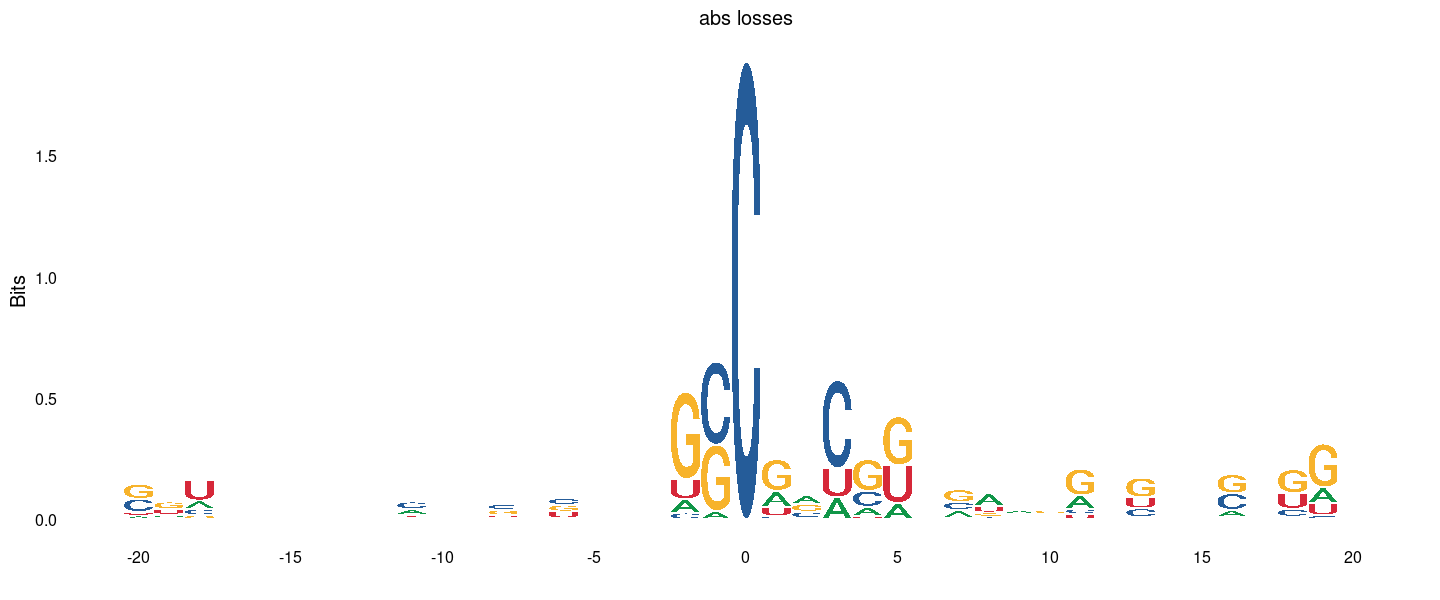

In [102]:
logos_d <- annotation2 %>% merge(d_unique_abs_loss_2304_1935, by = 'position', all.y=TRUE) %>%
    distinct(position, .keep_all = TRUE) %>%
    dplyr::select(-strain)
options(repr.plot.width=12, repr.plot.height=5)

ggplot() + 
    geom_logo(logos_d$logos_sequence_41bp, method='bit' ) + 
    theme_logo() +
    labs(title = 'abs losses') +
    theme(plot.title = element_text(size=12,hjust = 0.5) ) +
    scale_x_continuous(breaks = c(1,6,11,16,21,26,31,36,41),
        labels = c(-20,-15,-10,-5,0,5,10,15,20))

ggsave('./figures/TK2304_19335_absloss_logos.pdf', device = 'pdf', dpi=200, height=1.5, width=4)


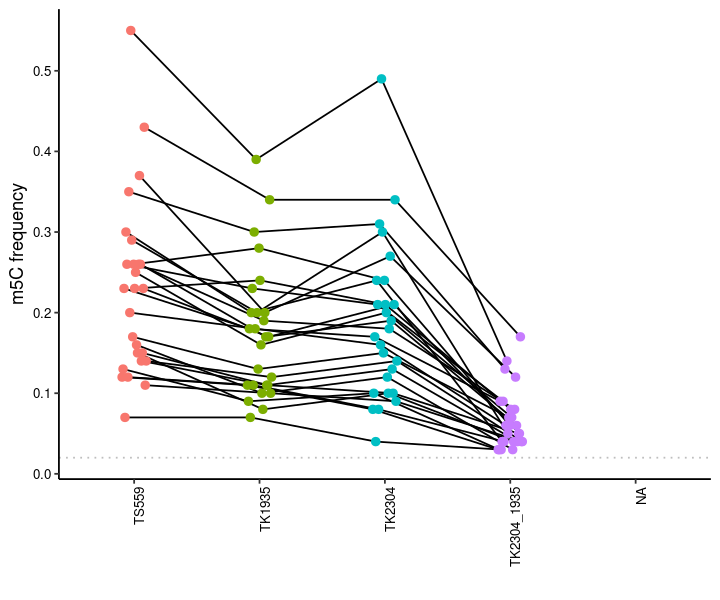

In [75]:
# relative loss


options(repr.plot.width=6, repr.plot.height=5)

d_unique_rel_loss_2304_1935<- d %>% merge(TK2304_1935_unique_rel_loss_ls, by = 'position', all.y=TRUE)

ggplot(d_unique_rel_loss_2304_1935, aes(y=pooled_methylation_frequency, x = strain)) +
    geom_line(aes(group=position), position = position_dodge(0.2)) +
    geom_point(aes(color=strain,group=position), size=2,position = position_dodge(0.2)) +
#     geom_errorbar(aes(ymin=pooled_methylation_frequency-sd, ymax=pooled_methylation_frequency+sd), width=.2,
#                  position=position_dodge(0.02)) +
    theme_classic() +
    #scale_color_manual(values=c('black')) +
    #scale_y_continuous(limits=c(0,0.15), breaks = c(0,0.02,0.05,0.10,0.15)) +
    geom_hline(yintercept=0.02, linetype="dotted", color='grey') +

    scale_x_discrete(labels = c("TS559",'TK1935', "TK2304", "TK2304_1935")) +

    labs(y='m5C frequency', x='') +

    theme(axis.text.x = element_text(size=8, angle = 90, hjust = 1, color = "black"),
          axis.text.y = element_text(color='black', size=8),
         legend.position = 'none')

ggsave('./figures/TK2304_19335_reloss_dot_line_frequencies.pdf', device = 'pdf', dpi=200, height=4, width=4)


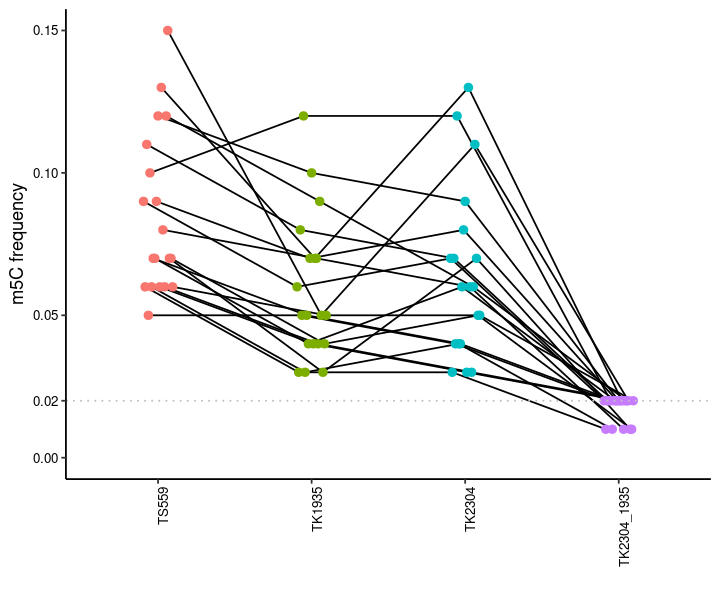

In [73]:
# absolute loss


options(repr.plot.width=6, repr.plot.height=5)

d_unique_abs_loss_2304_1935 <- d %>% merge(TK2304_1935_unique_abs_loss_ls, by = 'position', all.y=TRUE)


ggplot(d_unique_abs_loss_2304_1935, aes(y=pooled_methylation_frequency, x = strain)) +
    geom_line(aes(group=position), position = position_dodge(0.2)) +
    geom_point(aes(color=strain,group=position), size=2,position = position_dodge(0.2)) +
#     geom_errorbar(aes(ymin=pooled_methylation_frequency-sd, ymax=pooled_methylation_frequency+sd), width=.2,
#                  position=position_dodge(0.02)) +
    theme_classic() +
    #scale_color_manual(values=c('black')) +
    scale_y_continuous(limits=c(0,0.15), breaks = c(0,0.02,0.05,0.10,0.15)) +
    geom_hline(yintercept=0.02, linetype="dotted", color='grey') +

    scale_x_discrete(labels = c("TS559",'TK1935', "TK2304", "TK2304_1935")) +

    labs(y='m5C frequency', x='') +

    theme(axis.text.x = element_text(size=8, angle = 90, hjust = 1, color = "black"),
          axis.text.y = element_text(color='black', size=8),
         legend.position = 'none')

ggsave('./figures/TK2304_19335_absloss_dot_line_frequencies.pdf', device = 'pdf', dpi=200, height=4, width=4)


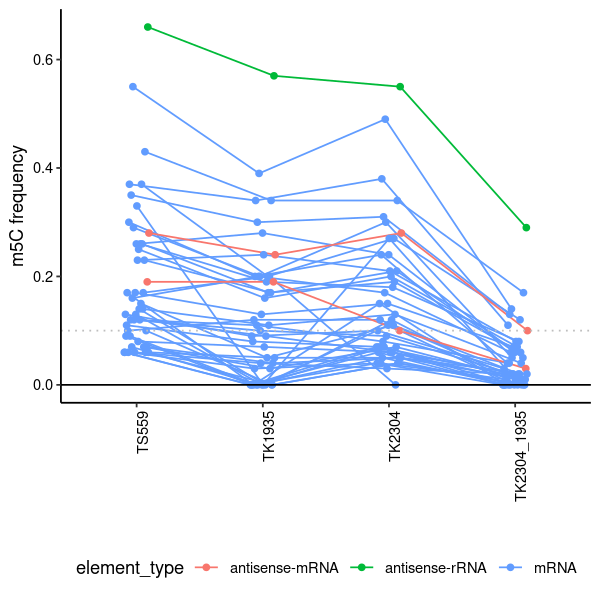

In [74]:
# all loss


defaultW <- getOption("warn")
options(warn = -1)

options(repr.plot.width=5, repr.plot.height=5)

ggplot(d %>% filter(element_type != 'rRNA'), aes(y=pooled_methylation_frequency, x = strain)) +
    geom_line(aes(group=position, color=element_type), position = position_dodge(0.2)) +
    geom_point(aes(color=element_type,group=position), position = position_dodge(0.2)) +
    theme_classic() +
    #scale_color_manual(values=c('black')) +
    #scale_y_continuous(limits=c(-.2,.5)) +
    geom_hline(yintercept=0) +
    geom_hline(yintercept=.10, linetype="dotted", color='grey') +

    scale_x_discrete(labels = c("TS559",'TK1935', "TK2304", "TK2304_1935")) +
    labs(y='m5C frequency', x='') +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, color = "black"),
          axis.text.y = element_text(color='black'),
         legend.position = 'bottom')

ggsave('./figures/TK2304_19335_all_dot_line_frequencies.pdf', device = 'pdf', dpi=200, height=4, width=5)


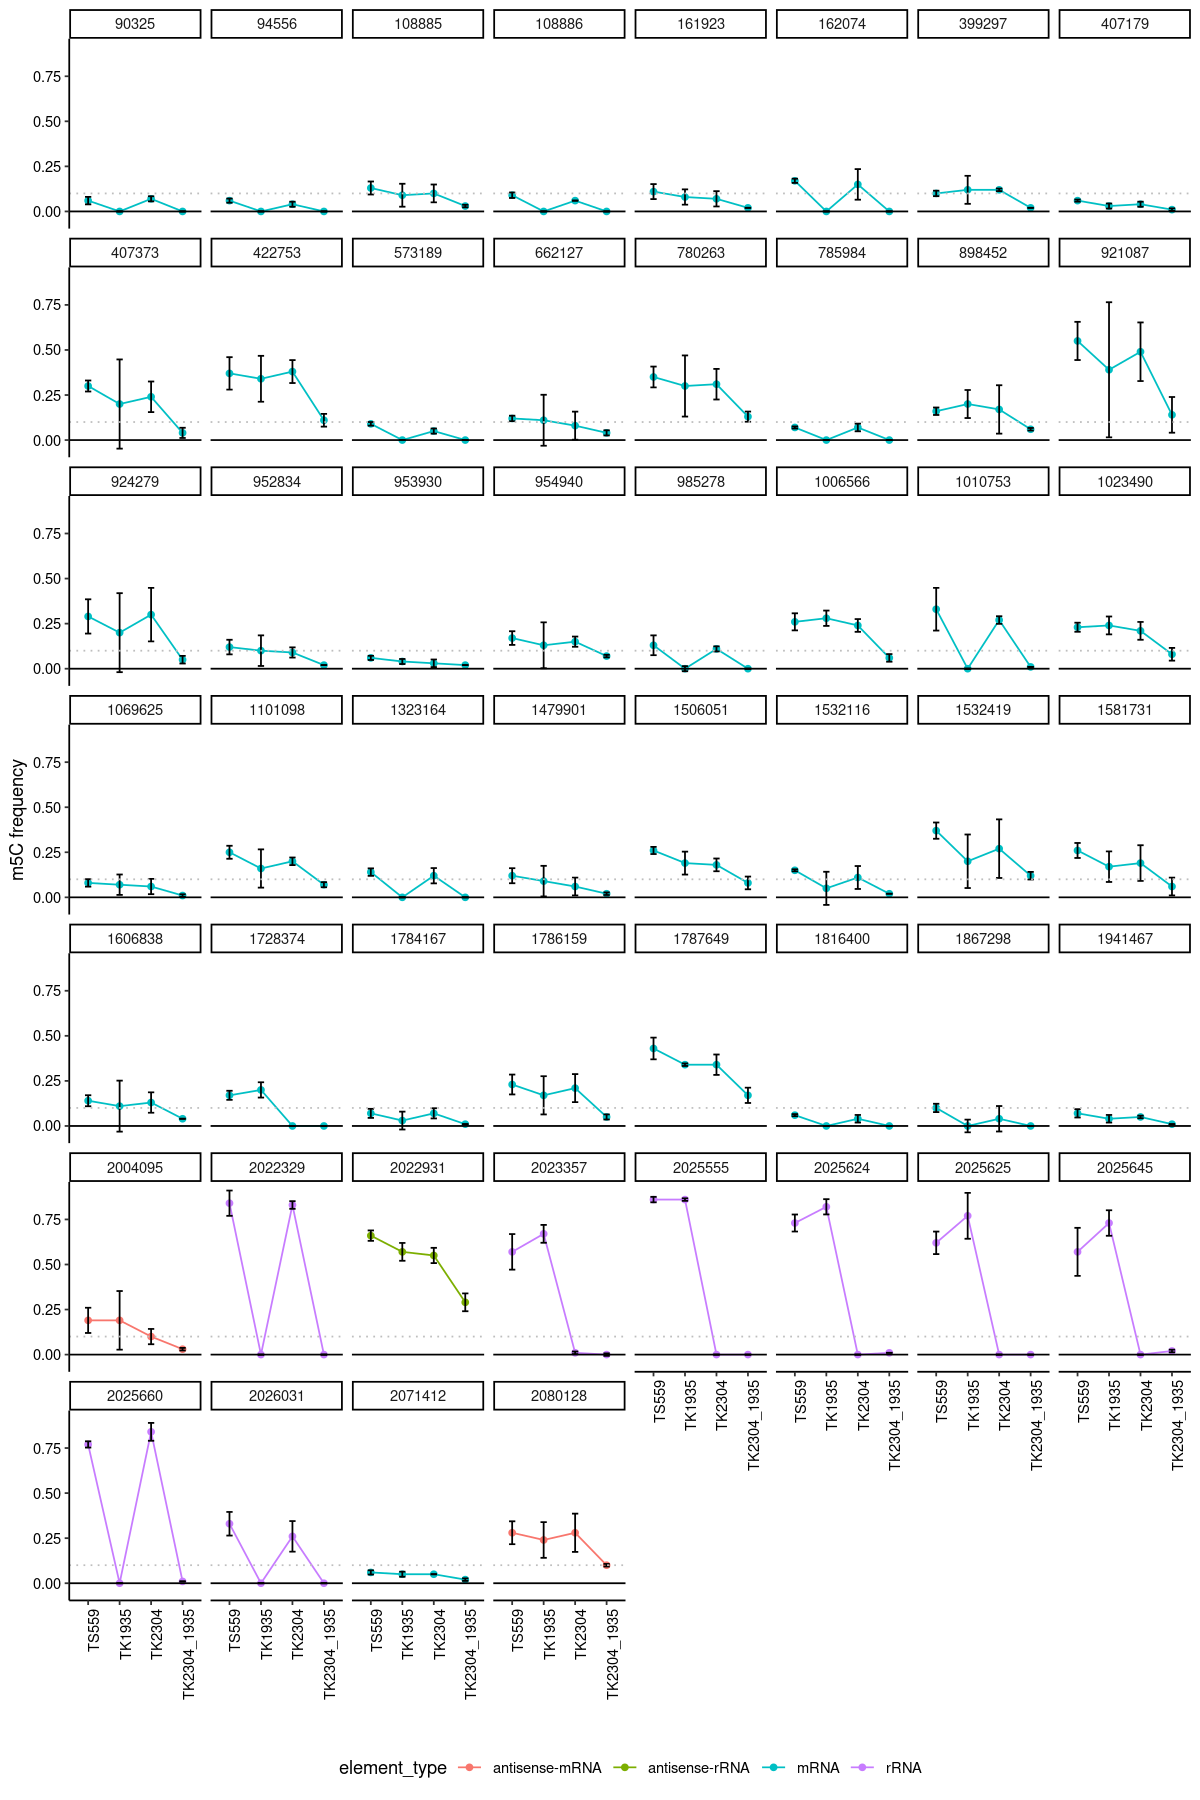

In [73]:
defaultW <- getOption("warn")
options(warn = -1)

options(repr.plot.width=10, repr.plot.height=15)


ggplot(d, aes(y=pooled_methylation_frequency, x = strain)) +
    geom_line(aes(group=position, color=element_type), position = position_dodge(0.2)) +
    geom_point(aes(color=element_type,group=position), position = position_dodge(0.2)) +
    geom_errorbar(aes(ymin=pooled_methylation_frequency-sd, ymax=pooled_methylation_frequency+sd), width=.2,
                 position=position_dodge(0.02)) +
    theme_classic() +
    #scale_color_manual(values=c('black')) +
    facet_wrap(~position)+
    #scale_y_continuous(limits=c(-.2,.5)) +
    geom_hline(yintercept=0) +
    geom_hline(yintercept=.10, linetype="dotted", color='grey') +

    scale_x_discrete(labels = c("TS559",'TK1935', "TK2304", "TK2304_1935")) +
    labs(y='m5C frequency', x='') +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, color = "black"),
          axis.text.y = element_text(color='black'),
         legend.position = 'bottom')

ggsave('./figures/TK2304_19335_all_dot_line_frequencies_facet.pdf', device = 'pdf', dpi=200, height=20, width=10)


# structural analysis

In [153]:
TK1935exoS_sd <- TK1935exoS_dd %>% 
    rowwise() %>%
    mutate(FC = log2((pooled_methylation_frequency_TK1935+.01)/(pooled_methylation_frequency_TS559+.01)) )%>% 
    filter(different_TK1935 == TRUE, FC <= -1)

s_1935exoS_65 <- TK1935exoS_sd %>%
    merge(folds_65C, all.x=TRUE, by = "TS559_position") %>%
    filter(local_41bp_predicted_fold != '.') %>%
    dplyr::select(TS559_position, element_name, local_41bp_predicted_fold)
  
s_1935exoS_85 <- TK1935exoS_sd %>%
    merge(folds_85C, all.x=TRUE, by = "TS559_position") %>%
    filter(local_41bp_predicted_fold != '.') %>%
    dplyr::select(TS559_position, element_name, local_41bp_predicted_fold)



s_1935exoS_65

TS559_position,element_name,local_41bp_predicted_fold
<int>,<chr>,<chr>
90325,TK0112,||||||||.....||||.....||||......|||||||.|
94556,TK0117,-----------------..||||||||....|||..||||.
108886,TK0135,....|||||||||||..||||||...........|||||||
162074,TK0194,|||....||||||.........||.||||||......||||
573189,TK0669,.....||||||||||||.......||||||||||||.....
785984,TK0901,.||||.....|||||........|||||||||||||||...
1010753,TK1152,||||||||.|..............||.|||||||||||...
1323164,TK1497,|||..|||||.||....||..|.||||.|||||.......|
1816400,TK2021,....|||||..||...||..|||||.....||||||...||


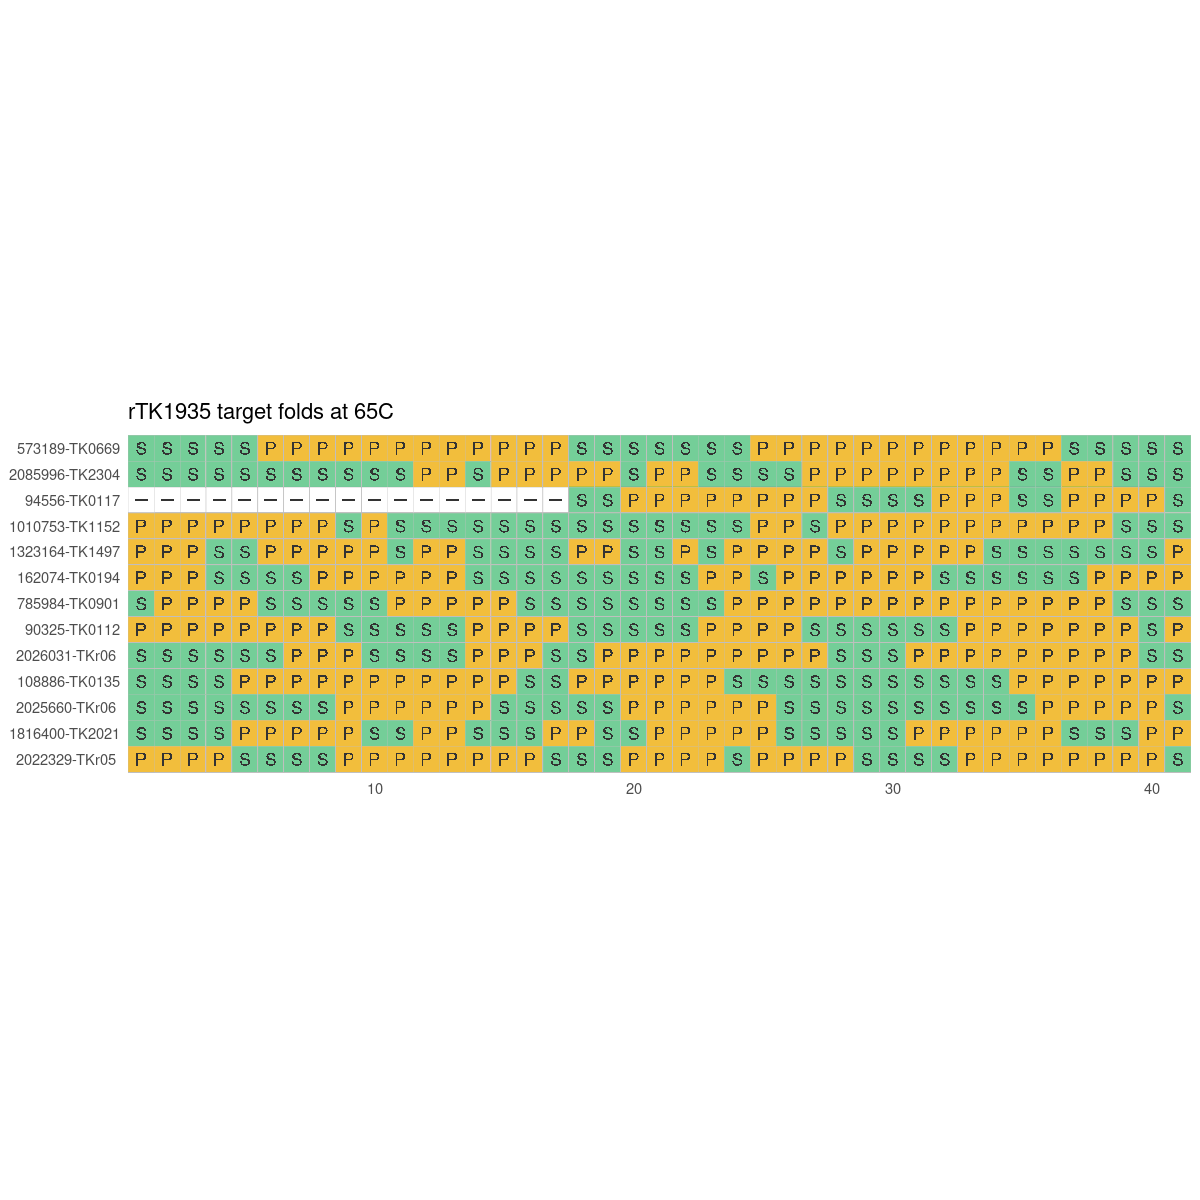

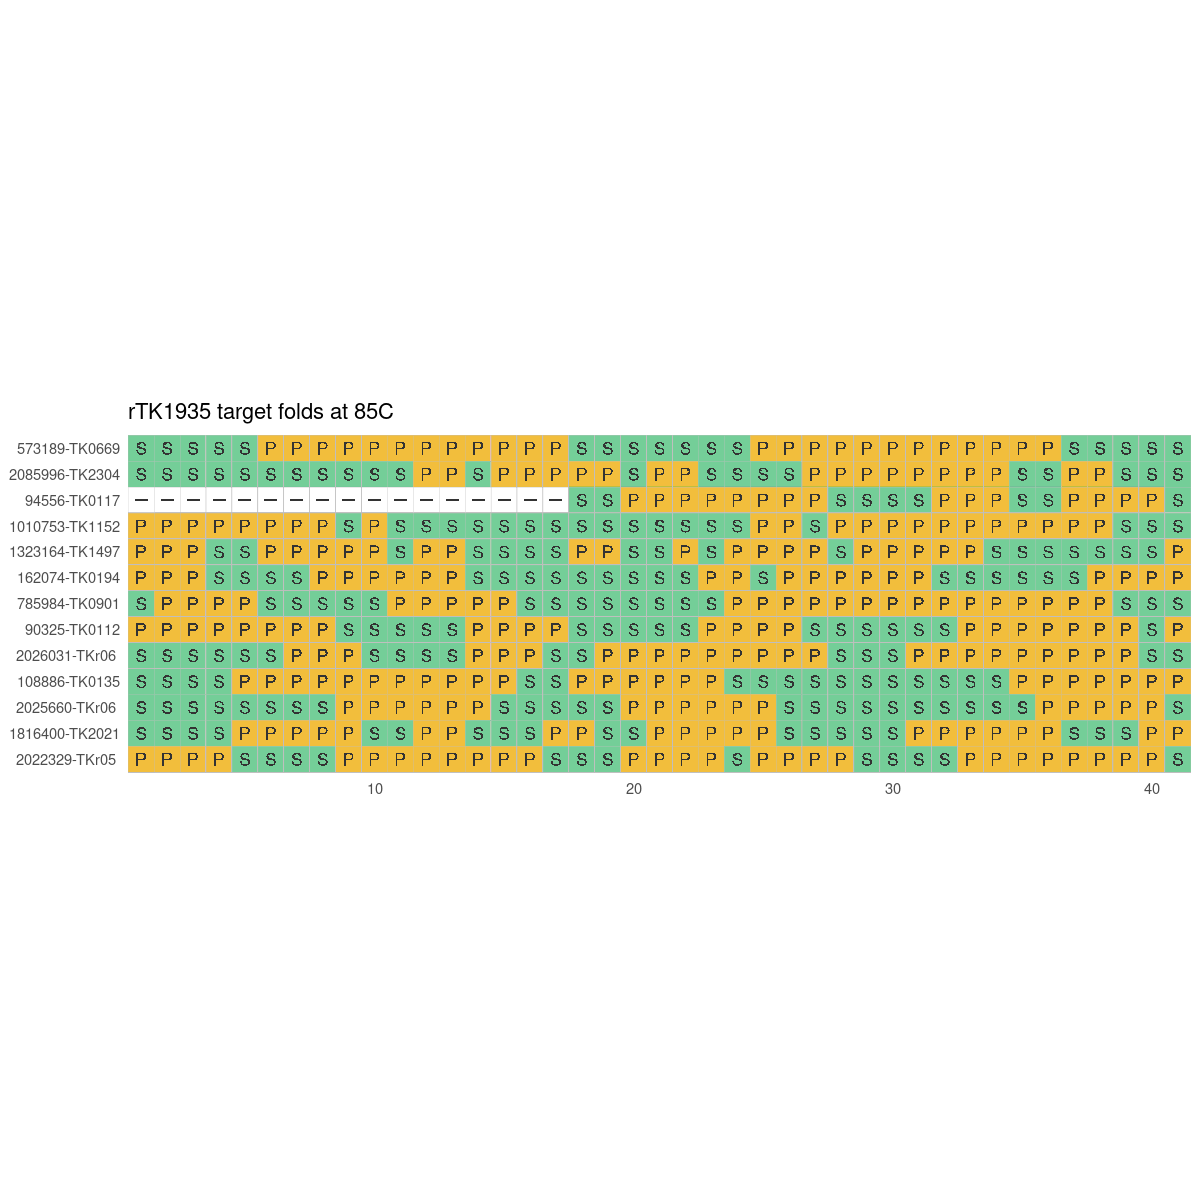

In [156]:
options(repr.plot.width=10, repr.plot.height=10)
aln <- file.path("./data/TK1935_41bp_fold_65C.fasta")
ggmsa(aln, char_width = 0.5, seq_name = TRUE ) +
    labs(title="rTK1935 target folds at 65C")

aln <- file.path("./data/TK1935_41bp_fold_85C.fasta")
ggmsa(aln, char_width = 0.5, seq_name = TRUE ) +
    labs(title="rTK1935 target folds at 85C")